In [4]:
! pip install uv
! uv pip install numpy pandas wfdb matplotlib ecgmentations pytorch_metric_learning scikit-learn --quiet
! uv pip install --upgrade --pre torch torchvision --index-url https://download.pytorch.org/whl/nightly/cu130

Using Python 3.12.3 environment at: /home/aimakeradmin/shady/Self-Supervied-Contrastive-Representation-Learning-ECG-Signals/.venv
Resolved 29 packages in 699ms                                        
⠹ Preparing packages... (2/3)                                                   
⠹ Preparing packages... (2/3)-------------------     0 B/501.43 MiB          
⠹ Preparing packages... (2/3)------------------- 8.00 KiB/501.43 MiB         
⠹ Preparing packages... (2/3)------------------- 16.00 KiB/501.43 MiB        
⠹ Preparing packages... (2/3)------------------- 16.43 KiB/501.43 MiB        
⠹ Preparing packages... (2/3)------------------- 24.43 KiB/501.43 MiB        
⠹ Preparing packages... (2/3)------------------- 32.43 KiB/501.43 MiB        
⠹ Preparing packages... (2/3)------------------- 40.43 KiB/501.43 MiB        
⠹ Preparing packages... (2/3)------------------- 48.43 KiB/501.43 MiB        
⠹ Preparing packages... (2/3)------------------- 56.43 KiB/501.43 MiB        
⠹ Preparing packa

In [5]:
import torch
torch.cuda.is_available(), torch.cuda.is_bf16_supported()


/home/aimakeradmin/shady/Self-Supervied-Contrastive-Representation-Learning-ECG-Signals/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:435: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  queued_call()


(True, True)

In [6]:
from src import CheckpointManager
from src import train
from src import ECGContrastiveTrainDataset, ECGDataset, DualAugmenter
from pytorch_metric_learning.losses import NTXentLoss

Creating simple baseline model...

Simple Model Summary:

Compare to complex model: 31.21M parameters


# Loading the dataset

## New Dataset

In [7]:
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

superclass_cols_defaults = ["NORM", "MI", "STTC", "HYP", "CD"]


def load_signal_cube(signal_csv: Union[str, Path],
                     expected_channels: Optional[List[str]] = None,
                     expected_len: Optional[int] = None) -> Tuple[np.ndarray, Dict[int, int], List[str], int]:
    df = pd.read_csv(signal_csv)
    if "ecg_id" not in df.columns:
        raise ValueError(f"Missing 'ecg_id' column in {signal_csv}")

    df = df.sort_values("ecg_id", kind="mergesort").reset_index(drop=True)
    channel_cols = [col for col in df.columns if col != "ecg_id"]
    if expected_channels is not None and channel_cols != expected_channels:
        raise ValueError("Channel layout differs across splits")

    counts = df.groupby("ecg_id", sort=False).size()
    lengths = counts.unique()
    if len(lengths) != 1:
        raise ValueError("Signals have inconsistent lengths; expected a fixed 1000-sample window")
    signal_len = int(lengths[0])
    if expected_len is not None and signal_len != expected_len:
        raise ValueError("Signal length differs across splits")

    signal_cube = df[channel_cols].to_numpy(dtype=np.float32).reshape(-1, signal_len, len(channel_cols))
    ecg_ids = counts.index.to_numpy()
    id_lookup = {int(eid): idx for idx, eid in enumerate(ecg_ids)}
    return signal_cube, id_lookup, channel_cols, signal_len


def extract_single_subclass(meta_csv: Union[str, Path],
                            subclass_cols: Optional[List[str]] = None,
                            superclass_cols: Optional[List[str]] = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray, int, List[str], List[str]]:
    meta_df = pd.read_csv(meta_csv)
    if "ecg_id" not in meta_df.columns:
        raise ValueError(f"Missing 'ecg_id' column in {meta_csv}")

    if subclass_cols is None:
        subclass_cols = [col for col in meta_df.columns if col.startswith("sub_")]
    missing_sub = [col for col in subclass_cols if col not in meta_df.columns]
    if missing_sub:
        raise ValueError(f"Columns {missing_sub} are missing from {meta_csv}")

    target_superclass_cols = superclass_cols or superclass_cols_defaults
    missing_super = [col for col in target_superclass_cols if col not in meta_df.columns]
    if missing_super:
        raise ValueError(f"Columns {missing_super} are missing from {meta_csv}")

    subset = meta_df[["ecg_id", *subclass_cols, *target_superclass_cols]].dropna(subset=["ecg_id"]).copy()
    subset["ecg_id"] = subset["ecg_id"].astype(int)
    subclass_values = subset[subclass_cols].fillna(0).astype(int).to_numpy()

    label_counts = (subclass_values > 0).sum(axis=1)
    single_mask = label_counts == 1
    dropped = int((~single_mask).sum())

    filtered_subset = subset[single_mask]
    filtered_ids = filtered_subset["ecg_id"].to_numpy()
    filtered_labels = np.array(subclass_cols)[subclass_values[single_mask].argmax(axis=1)]
    superclass_values = filtered_subset[target_superclass_cols].fillna(0).astype(int).to_numpy()

    return filtered_ids, filtered_labels, superclass_values, dropped, subclass_cols, target_superclass_cols


data_root = Path("/home/aimakeradmin/shady/Self-Supervied-Contrastive-Representation-Learning-ECG-Signals/data/raw")
split_paths = {
    "train": {
        "signal": data_root / "train_signal.csv",
        "meta": data_root / "train_meta.csv",
    },
    "val": {
        "signal": data_root / "valid_signal.csv",
        "meta": data_root / "valid_meta.csv",
    },
    "test": {
        "signal": data_root / "test_signal.csv",
        "meta": data_root / "test_meta.csv",
    },
}

csv_splits: Dict[str, Dict[str, np.ndarray]] = {}
expected_channels: Optional[List[str]] = None
expected_len: Optional[int] = None
subclass_cols: Optional[List[str]] = None
superclass_cols: Optional[List[str]] = None

for split_name, paths in split_paths.items():
    signals, lookup, channel_cols, signal_len = load_signal_cube(
        paths["signal"], expected_channels=expected_channels, expected_len=expected_len
    )
    if expected_channels is None:
        expected_channels = channel_cols
    if expected_len is None:
        expected_len = signal_len

    ids, labels, superclass_values, dropped, subclass_cols, detected_superclasses = extract_single_subclass(
        paths["meta"], subclass_cols=subclass_cols, superclass_cols=superclass_cols
    )

    if superclass_cols is None:
        superclass_cols = detected_superclasses

    missing = [eid for eid in ids if eid not in lookup]
    if missing:
        raise ValueError(f"{split_name} meta rows missing signal data: {missing[:3]} ...")

    ordered_indices = [lookup[int(eid)] for eid in ids]
    csv_splits[split_name] = {
        "X": signals[ordered_indices],
        "labels": labels,
        "ecg_ids": ids,
        "dropped_multi_label": dropped,
        "superclasses": superclass_values,
    }

label_encoder = LabelEncoder()
label_encoder.fit(
    np.concatenate([csv_splits["train"]["labels"], csv_splits["val"]["labels"], csv_splits["test"]["labels"]])
)

for split_data in csv_splits.values():
    split_data["y_int"] = label_encoder.transform(split_data["labels"])

label_to_idx = {label: int(idx) for idx, label in enumerate(label_encoder.classes_)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

X_train_filtered = csv_splits["train"]["X"]
y_train_int = csv_splits["train"]["y_int"]
X_val_filtered = csv_splits["val"]["X"]
y_val_int = csv_splits["val"]["y_int"]
X_test_filtered = csv_splits["test"]["X"]
y_test_int = csv_splits["test"]["y_int"]

Y_train_superclasses = csv_splits["train"]["superclasses"]
Y_val_superclasses = csv_splits["val"]["superclasses"]
Y_test_superclasses = csv_splits["test"]["superclasses"]

print("Loaded CSV-based splits (after filtering to single subclass per record):")
for split_name in ["train", "val", "test"]:
    split = csv_splits[split_name]
    print(
        f"  {split_name.title():>5}: X={split['X'].shape}, unique subclasses={np.unique(split['labels']).size}, "
        f"dropped multi-label rows={split['dropped_multi_label']}, superclasses shape={split['superclasses'].shape}"
    )
print(f"Subclass count: {len(label_encoder.classes_)}")
print(f"Superclass columns: {superclass_cols}")

Loaded CSV-based splits (after filtering to single subclass per record):
  Train: X=(12123, 1000, 12), unique subclasses=22, dropped multi-label rows=5318, superclasses shape=(12123, 5)
    Val: X=(1555, 1000, 12), unique subclasses=20, dropped multi-label rows=638, superclasses shape=(1555, 5)
   Test: X=(1561, 1000, 12), unique subclasses=21, dropped multi-label rows=642, superclasses shape=(1561, 5)
Subclass count: 23
Superclass columns: ['NORM', 'MI', 'STTC', 'HYP', 'CD']


### Prepare CSV-based train/val/test splits
Run this section when you want to drive the rest of the notebook with the reformatted CSV exports (skipping the older PTB-XL reader below).

## Older Dataset

In [8]:
import ast

import numpy as np
import pandas as pd
import wfdb


def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path + "/" + f) for f in df.filename_lr[:1500]]
    else:
        data = [wfdb.rdsamp(path + "/" + f) for f in df.filename_hr[:1500]]
    data = np.array([signal for signal, meta in data])
    return data


path = "/home/aimakeradmin/shady/Self-Supervied-Contrastive-Representation-Learning-ECG-Signals/data/raw/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1"
sampling_rate = 100

# load and convert annotation data
Y = pd.read_csv(path + "/ptbxl_database.csv", index_col="ecg_id")[:1500]
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path + "/scp_statements.csv", index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]


def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))


# Apply diagnostic superclass
Y["diagnostic_superclass"] = Y.scp_codes.apply(aggregate_diagnostic)




# Split data into train, validation, and test
test_fold = 10
val_fold = 9
# Train
X_train = X[np.where((Y.strat_fold != test_fold) & (Y.strat_fold != val_fold))]
y_train = Y[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)].diagnostic_superclass
# Validation
X_val = X[np.where(Y.strat_fold == val_fold)]
y_val = Y[Y.strat_fold == val_fold].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass


In [9]:
X_val.shape, X_test.shape, X_train.shape

((188, 1000, 12), (194, 1000, 12), (1118, 1000, 12))

In [10]:
# Check the data structure - see examples of diagnostic_superclass
print("Sample y_train values:")
print(y_train.head(10))
print("\nValue counts:")
print(y_train.apply(lambda x: len(x) if isinstance(x, list) else 0).value_counts())
print("\nSample with multiple labels:")
multi_label_examples = y_train[y_train.apply(lambda x: isinstance(x, list) and len(x) > 1)]
print(f"Found {len(multi_label_examples)} samples with multiple labels")
if len(multi_label_examples) > 0:
    print(multi_label_examples.head())

Sample y_train values:
ecg_id
1     [NORM]
2     [NORM]
3     [NORM]
4     [NORM]
5     [NORM]
6     [NORM]
7     [NORM]
11    [NORM]
12    [NORM]
13    [NORM]
Name: diagnostic_superclass, dtype: object

Value counts:
diagnostic_superclass
1    879
2    186
3     34
4     14
0      5
Name: count, dtype: int64

Sample with multiple labels:
Found 234 samples with multiple labels
ecg_id
45      [HYP, CD]
50       [MI, CD]
77       [MI, CD]
87     [STTC, CD]
102    [STTC, CD]
Name: diagnostic_superclass, dtype: object


In [11]:
# Get all unique diagnostic classes
all_labels = []
for labels_list in pd.concat([y_train, y_val, y_test]):
    if isinstance(labels_list, list):
        all_labels.extend(labels_list)

unique_diagnostic_classes = sorted(set(all_labels))
print(f"Unique diagnostic classes: {unique_diagnostic_classes}")
print(f"Total number of classes: {len(unique_diagnostic_classes)}")

Unique diagnostic classes: ['CD', 'HYP', 'MI', 'NORM', 'STTC']
Total number of classes: 5


In [12]:
# Filter out rows with multiple labels (keep only single-label samples)
def filter_single_label(y_series, X_array):
    """Filter to keep only samples with exactly one label"""
    single_label_mask = y_series.apply(lambda x: isinstance(x, list) and len(x) == 1)
    y_filtered = y_series[single_label_mask].copy()
    X_filtered = X_array[single_label_mask.values]
    return X_filtered, y_filtered

# Apply filtering to train, val, and test sets
X_train_filtered, y_train_filtered = filter_single_label(y_train, X_train)
X_val_filtered, y_val_filtered = filter_single_label(y_val, X_val)
X_test_filtered, y_test_filtered = filter_single_label(y_test, X_test)

print("Original sizes:")
print(f"Train: {len(y_train)}, Val: {len(y_val)}, Test: {len(y_test)}")
print("\nFiltered sizes (single label only):")
print(f"Train: {len(y_train_filtered)}, Val: {len(y_val_filtered)}, Test: {len(y_test_filtered)}")
print(f"\nRemoved {len(y_train) - len(y_train_filtered)} multi-label samples from train")
print(f"Removed {len(y_val) - len(y_val_filtered)} multi-label samples from val")
print(f"Removed {len(y_test) - len(y_test_filtered)} multi-label samples from test")

Original sizes:
Train: 1118, Val: 188, Test: 194

Filtered sizes (single label only):
Train: 879, Val: 133, Test: 153

Removed 239 multi-label samples from train
Removed 55 multi-label samples from val
Removed 41 multi-label samples from test


In [13]:
# Create label mapping from diagnostic class strings to integers
label_to_idx = {label: idx for idx, label in enumerate(unique_diagnostic_classes)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

print("Label mapping:")
for label, idx in label_to_idx.items():
    print(f"  {label} -> {idx}")

# Convert labels from list of strings to integers
def map_labels_to_int(y_series, label_mapping):
    """Convert single-element label lists to integer labels"""
    return y_series.apply(lambda x: label_mapping[x[0]])

y_train_int = map_labels_to_int(y_train_filtered, label_to_idx)
y_val_int = map_labels_to_int(y_val_filtered, label_to_idx)
y_test_int = map_labels_to_int(y_test_filtered, label_to_idx)

print("\nLabel distribution in train set:")
print(y_train_int.value_counts().sort_index())
print("\nLabel distribution in val set:")
print(y_val_int.value_counts().sort_index())
print("\nLabel distribution in test set:")
print(y_test_int.value_counts().sort_index())

Label mapping:
  CD -> 0
  HYP -> 1
  MI -> 2
  NORM -> 3
  STTC -> 4

Label distribution in train set:
diagnostic_superclass
0     84
1     29
2     68
3    589
4    109
Name: count, dtype: int64

Label distribution in val set:
diagnostic_superclass
0    11
1     3
2    12
3    86
4    21
Name: count, dtype: int64

Label distribution in test set:
diagnostic_superclass
0    15
1     3
2    15
3    99
4    21
Name: count, dtype: int64


# Data Augmenter and Dataset Classes

In [14]:
# Create classification datasets
# The training dataset will compute the normalization stats
# Val and test will reuse those stats for consistency

train_dataset_classification = ECGDataset(
    X=X_train_filtered,
    y=y_train_int
)

# Reuse training stats for validation and test
val_dataset_classification = ECGDataset(
    X=X_val_filtered,
    y=y_val_int,
    channel_means=train_dataset_classification.channel_means,
    channel_stds=train_dataset_classification.channel_stds
)

test_dataset_classification = ECGDataset(
    X=X_test_filtered,
    y=y_test_int,
    channel_means=train_dataset_classification.channel_means,
    channel_stds=train_dataset_classification.channel_stds
)

print(f"Train dataset size: {len(train_dataset_classification)}")
print(f"Validation dataset size: {len(val_dataset_classification)}")
print(f"Test dataset size: {len(test_dataset_classification)}")
print(f"Number of classes: {test_dataset_classification.num_classes}")

print(f"\nNormalization stats computed from training set:")
print(f"  Channel means shape: {train_dataset_classification.channel_means.shape}")
print(f"  Channel stds shape: {train_dataset_classification.channel_stds.shape}")
print(f"  Std range: [{train_dataset_classification.channel_stds.min():.6f}, {train_dataset_classification.channel_stds.max():.6f}]")

# Test a sample
sample_signal, sample_label = val_dataset_classification[-1]
print(f"\nSample signal shape: {sample_signal.shape}")
print(f"Sample label (numerical): {sample_label}")

Train dataset size: 879
Validation dataset size: 133
Test dataset size: 153
Number of classes: 5

Normalization stats computed from training set:
  Channel means shape: (12,)
  Channel stds shape: (12,)
  Std range: [0.115345, 0.326835]

Sample signal shape: torch.Size([1000, 12])
Sample label (numerical): 3


In [15]:
# Create DataLoaders for classification training
from torch.utils.data import DataLoader

batch_size = 64

train_loader_classification = DataLoader(
    train_dataset_classification, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader_classification = DataLoader(
    val_dataset_classification, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader_classification = DataLoader(
    test_dataset_classification, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Created DataLoaders for classification:")
print(f"  Train: {len(train_dataset_classification)} samples, {len(train_loader_classification)} batches")
print(f"  Val:   {len(val_dataset_classification)} samples, {len(val_loader_classification)} batches")
print(f"  Test:  {len(test_dataset_classification)} samples, {len(test_loader_classification)} batches")

# Verify the data format
for signals, labels in train_loader_classification:
    print(f"\nBatch shapes:")
    print(f"  Signals: {signals.shape}")  # Should be (batch_size, time_steps, num_channels)
    print(f"  Labels: {labels.shape}, dtype: {labels.dtype}")  # Should be (batch_size,) with int dtype
    print(f"  Label range: [{labels.min()}, {labels.max()}]")
    break

Created DataLoaders for classification:
  Train: 879 samples, 14 batches
  Val:   133 samples, 3 batches
  Test:  153 samples, 3 batches

Batch shapes:
  Signals: torch.Size([64, 1000, 12])
  Labels: torch.Size([64]), dtype: torch.int64
  Label range: [0, 4]


# Custom Augmentations.

In [16]:
import ecgmentations as E
from scipy.spatial.distance import cosine
import torch

# Define augmentation pool
augmentation_pool = [
    E.TimeShift(p=1.0),
    E.GaussNoise(p=1.0),
    E.PowerlineNoise(p=1.0, ecg_frequency=60),
    E.RespirationNoise(p=1.0),
    E.AmplitudeScale(p=1.0),
    E.TimeCutout(p=1.0),
]

# Create dual augmenter with both min and max similarity thresholds
dual_augmenter = DualAugmenter(
    augmentation_pool=augmentation_pool,
    min_similarity=0.35,   # Augmentations must be at least 35% similar
    max_similarity=0.80,  # But not more than 80% similar
    max_retries=5,
)

# Create contrastive datasets
# Training dataset computes normalization stats
train_dataset = ECGContrastiveTrainDataset(
    X=X_train_filtered, 
    y=y_train_int, 
    dual_augmenter=dual_augmenter
)

# Val and test reuse training stats
val_dataset = ECGContrastiveTrainDataset(
    X=X_val_filtered, 
    y=y_val_int, 
    dual_augmenter=dual_augmenter,
    channel_means=train_dataset.channel_means,
    channel_stds=train_dataset.channel_stds
)

test_dataset = ECGContrastiveTrainDataset(
    X=X_test_filtered, 
    y=y_test_int, 
    dual_augmenter=dual_augmenter,
    channel_means=train_dataset.channel_means,
    channel_stds=train_dataset.channel_stds
)

print(f"✓ Created contrastive datasets")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Val: {len(val_dataset)} samples")
print(f"  Test: {len(test_dataset)} samples")

print(f"\n✓ Normalization stats from training set:")
print(f"  Channel means: {train_dataset.channel_means}")
print(f"  Channel stds: {train_dataset.channel_stds}")

# Test augmentation on a sample from the dataset
aug1, aug2 = train_dataset[0]
print(f"\n✓ Sample augmentation test:")
print(f"  Aug1 shape: {aug1.shape}")
print(f"  Aug2 shape: {aug2.shape}")
print(f"  Are they identical? {torch.equal(aug1, aug2)}")

# Calculate similarity between augmented views
similarity = 1 - cosine(aug1.numpy().flatten(), aug2.numpy().flatten())
print(f"  Cosine similarity: {similarity:.4f}")
print(f"  Within range [{dual_augmenter.min_similarity}, {dual_augmenter.max_similarity}]? "
      f"{dual_augmenter.min_similarity <= similarity <= dual_augmenter.max_similarity}")

✓ Created contrastive datasets
  Train: 879 samples
  Val: 133 samples
  Test: 153 samples

✓ Normalization stats from training set:
  Channel means: [-3.4150627e-04 -6.8282141e-05  2.7284413e-04  1.9833447e-04
 -2.5447327e-04  1.2692378e-04  1.8271331e-04 -7.0365530e-04
 -1.6193549e-03 -1.2210956e-03 -1.9506940e-04 -4.0522413e-04]
  Channel stds: [0.14577079 0.16198245 0.13595659 0.13831232 0.11534519 0.13042206
 0.21829572 0.32683456 0.29962364 0.27906758 0.27387643 0.24801815]

✓ Sample augmentation test:
  Aug1 shape: torch.Size([1000, 12])
  Aug2 shape: torch.Size([1000, 12])
  Are they identical? False
  Cosine similarity: 0.7630
  Within range [0.35, 0.8]? True


Visualize the signals?

# Visualization

## Visualization: Raw Data

Let's visualize some raw ECG signals before any preprocessing to understand the data structure.

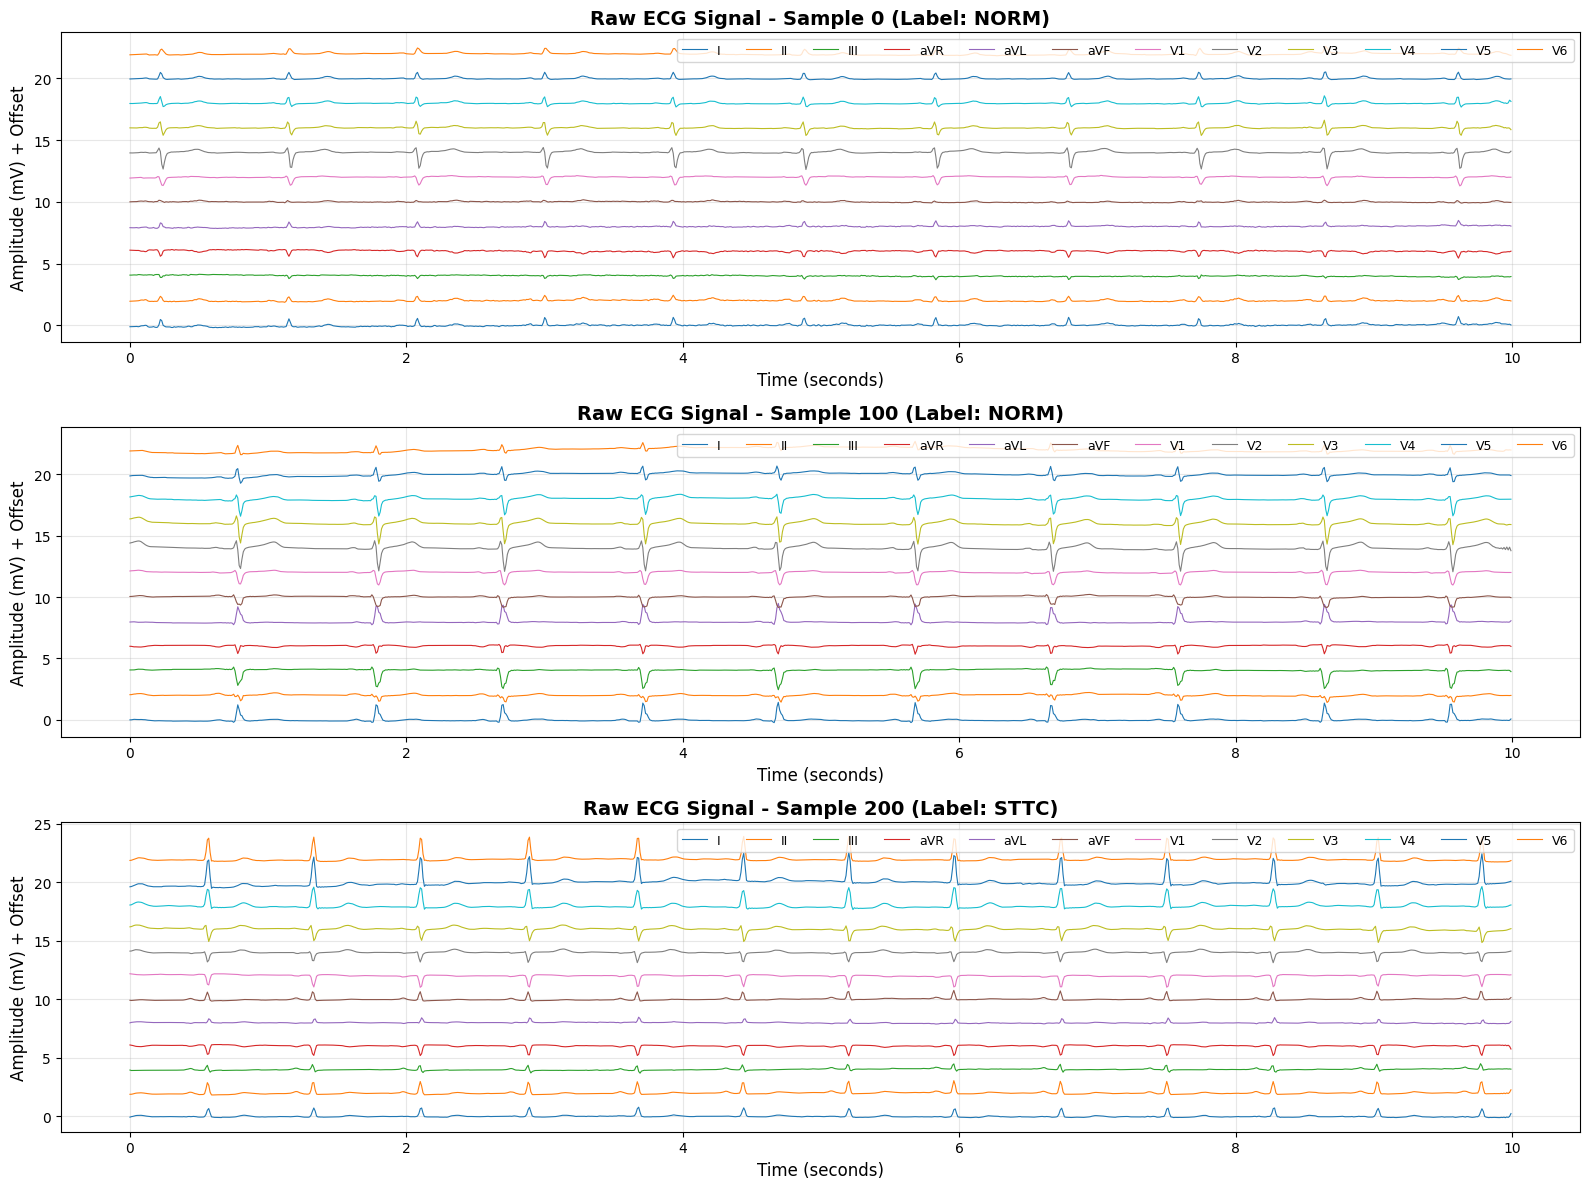

Raw signal shape (time, channels): (1000, 12)
Value range: [-11.1440, 8.2470]
Mean: -0.0003, Std: 0.2187
Sampling rate assumed for visualizations: 100 Hz


In [18]:
import matplotlib.pyplot as plt
import numpy as np

SAMPLING_RATE = 100  # Hz sampling rate used by PTB-XL low-resolution signals

# Select a few samples to visualize
sample_indices = [0, 100, 200]  # Different samples
lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

fig, axes = plt.subplots(len(sample_indices), 1, figsize=(16, 4 * len(sample_indices)))
if len(sample_indices) == 1:
    axes = [axes]

for idx, sample_idx in enumerate(sample_indices):
    # Get raw signal
    raw_signal = X_train_filtered[sample_idx]  # Shape: (time_steps, 12)
    label = y_train_int.iloc[sample_idx]
    
    ax = axes[idx]
    
    # Plot all 12 leads
    time_axis = np.arange(raw_signal.shape[0]) / SAMPLING_RATE
    
    for lead_idx in range(12):
        # Offset each lead for visibility
        offset = lead_idx * 2
        ax.plot(time_axis, raw_signal[:, lead_idx] + offset, label=lead_names[lead_idx], linewidth=0.8)
    
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Amplitude (mV) + Offset', fontsize=12)
    ax.set_title(f'Raw ECG Signal - Sample {sample_idx} (Label: {idx_to_label[label]})', 
                 fontsize=14, fontweight='bold')
    ax.legend(ncol=12, loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Raw signal shape (time, channels): {raw_signal.shape}")
print(f"Value range: [{X_train_filtered.min():.4f}, {X_train_filtered.max():.4f}]")
print(f"Mean: {X_train_filtered.mean():.4f}, Std: {X_train_filtered.std():.4f}")
print(f"Sampling rate assumed for visualizations: {SAMPLING_RATE} Hz")

## Visualization: After Preprocessing (Normalized)

Now let's see the same signals after preprocessing (normalization).
Each tensor coming from `train_dataset_classification` is already shaped as `(time_steps, channels)`,
so the plots below directly reuse that convention and only offset each lead for readability.

Example preprocessed tensor shape (time, channels): (1000, 12)


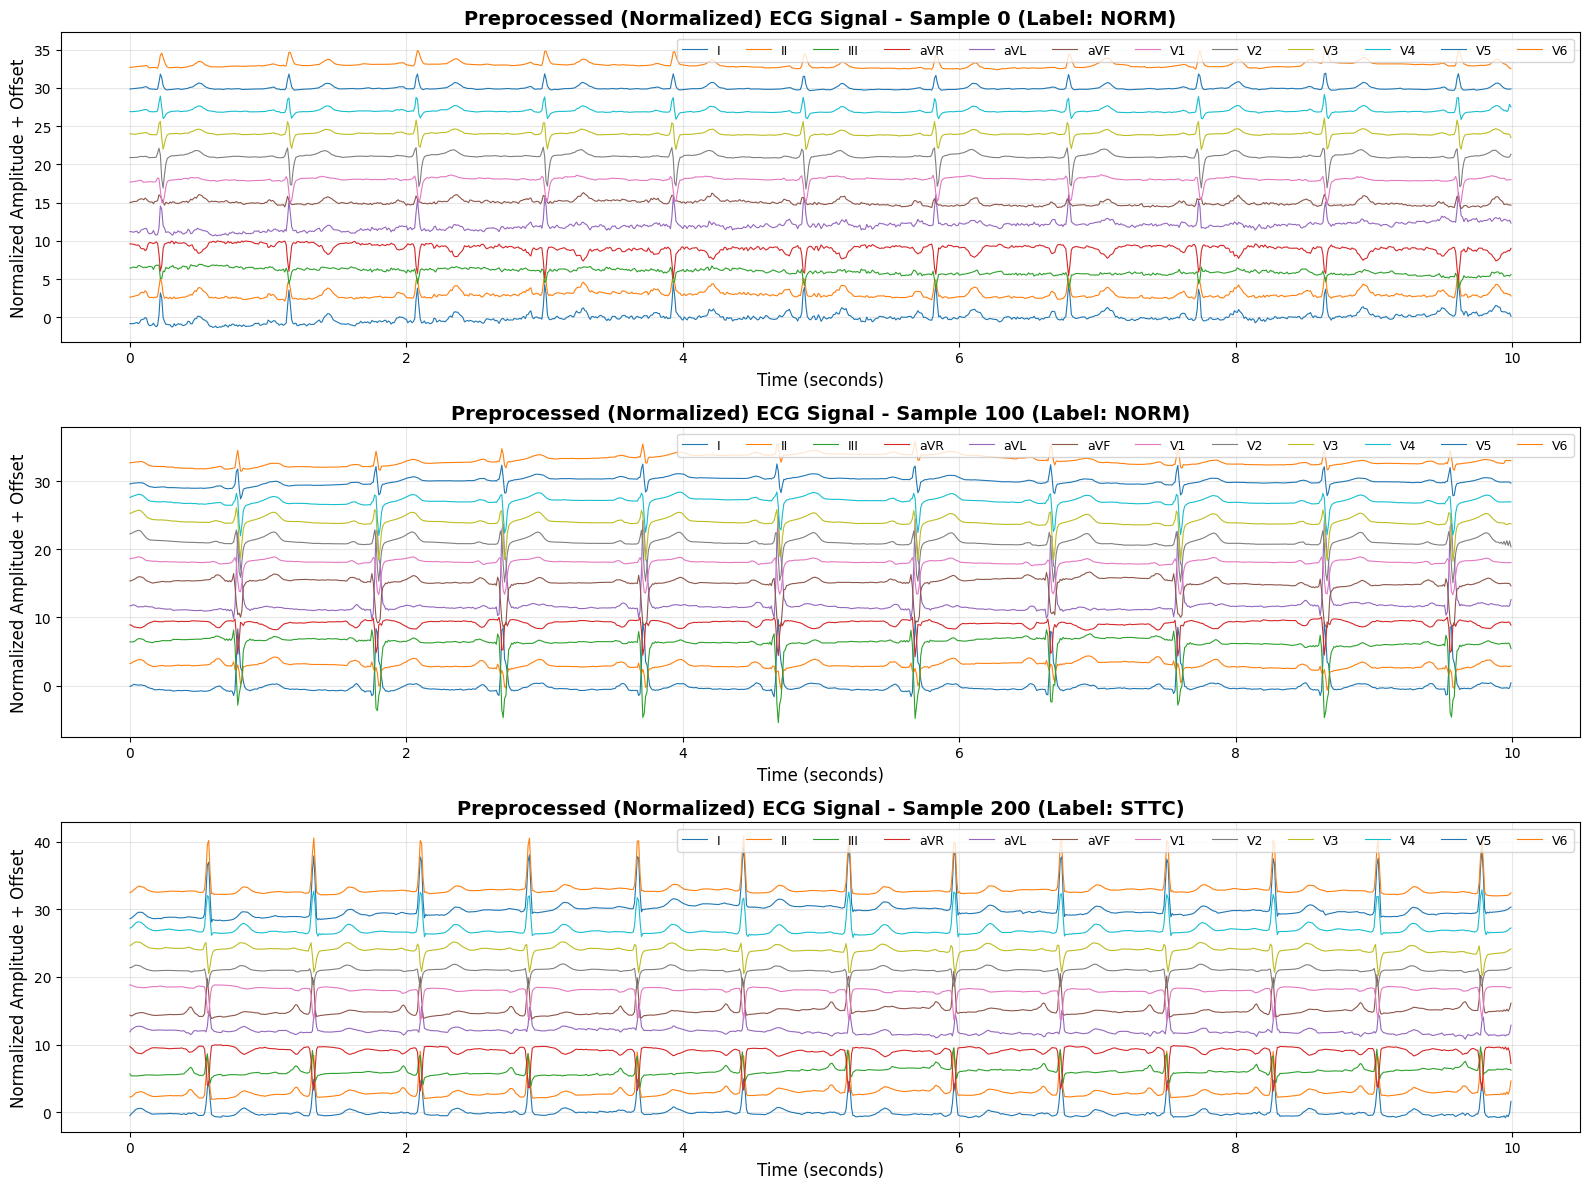

Preprocessed signal shape (time, channels): (1000, 12)
Value range: [-6.0240, 9.4356]
Mean per channel: 0.000224
Std per channel: 0.869147

Normalization stats used:
  Channel means: min=-0.0016, max=0.0003
  Channel stds: min=0.115345, max=0.326835


In [19]:
fig, axes = plt.subplots(len(sample_indices), 1, figsize=(16, 4 * len(sample_indices)))
if len(sample_indices) == 1:
    axes = [axes]

dataset_shape_logged = False
last_preprocessed_np = None

for idx, sample_idx in enumerate(sample_indices):
    # Get preprocessed signal from the dataset (time_steps, num_channels)
    preprocessed_signal, label = train_dataset_classification[sample_idx]
    preprocessed_np = preprocessed_signal.numpy()
    last_preprocessed_np = preprocessed_np
    
    if not dataset_shape_logged:
        print(f"Example preprocessed tensor shape (time, channels): {preprocessed_np.shape}")
        dataset_shape_logged = True
    
    ax = axes[idx]
    
    # Plot all 12 leads
    time_axis = np.arange(preprocessed_np.shape[0]) / SAMPLING_RATE
    
    for lead_idx in range(12):
        offset = lead_idx * 3  # Slightly larger offset for normalized data
        ax.plot(time_axis, preprocessed_np[:, lead_idx] + offset, 
                label=lead_names[lead_idx], linewidth=0.8)
    
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Normalized Amplitude + Offset', fontsize=12)
    ax.set_title(f'Preprocessed (Normalized) ECG Signal - Sample {sample_idx} (Label: {idx_to_label[label]})', 
                 fontsize=14, fontweight='bold')
    ax.legend(ncol=12, loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

if last_preprocessed_np is not None:
    print(f"Preprocessed signal shape (time, channels): {last_preprocessed_np.shape}")
    print(f"Value range: [{last_preprocessed_np.min():.4f}, {last_preprocessed_np.max():.4f}]")
    print(f"Mean per channel: {last_preprocessed_np.mean(axis=0).mean():.6f}")
    print(f"Std per channel: {last_preprocessed_np.std(axis=0).mean():.6f}")
print(f"\nNormalization stats used:")
print(f"  Channel means: min={train_dataset_classification.channel_means.min():.4f}, max={train_dataset_classification.channel_means.max():.4f}")
print(f"  Channel stds: min={train_dataset_classification.channel_stds.min():.6f}, max={train_dataset_classification.channel_stds.max():.6f}")

## Visualization: After Augmentation (Contrastive Learning)

Finally, let's see how augmentations create two different views of the same signal for contrastive learning.
The augmented tensors also follow the `(time_steps, channels)` layout, which keeps the interpretation consistent across the pipeline.

Augmented tensor shape (time, channels): (1000, 12)
Pair 1 - Cosine Similarity: 0.9118
  Within target range [0.35, 0.8]? False
Pair 2 - Cosine Similarity: 0.5799
  Within target range [0.35, 0.8]? True
Pair 3 - Cosine Similarity: 0.7764
  Within target range [0.35, 0.8]? True


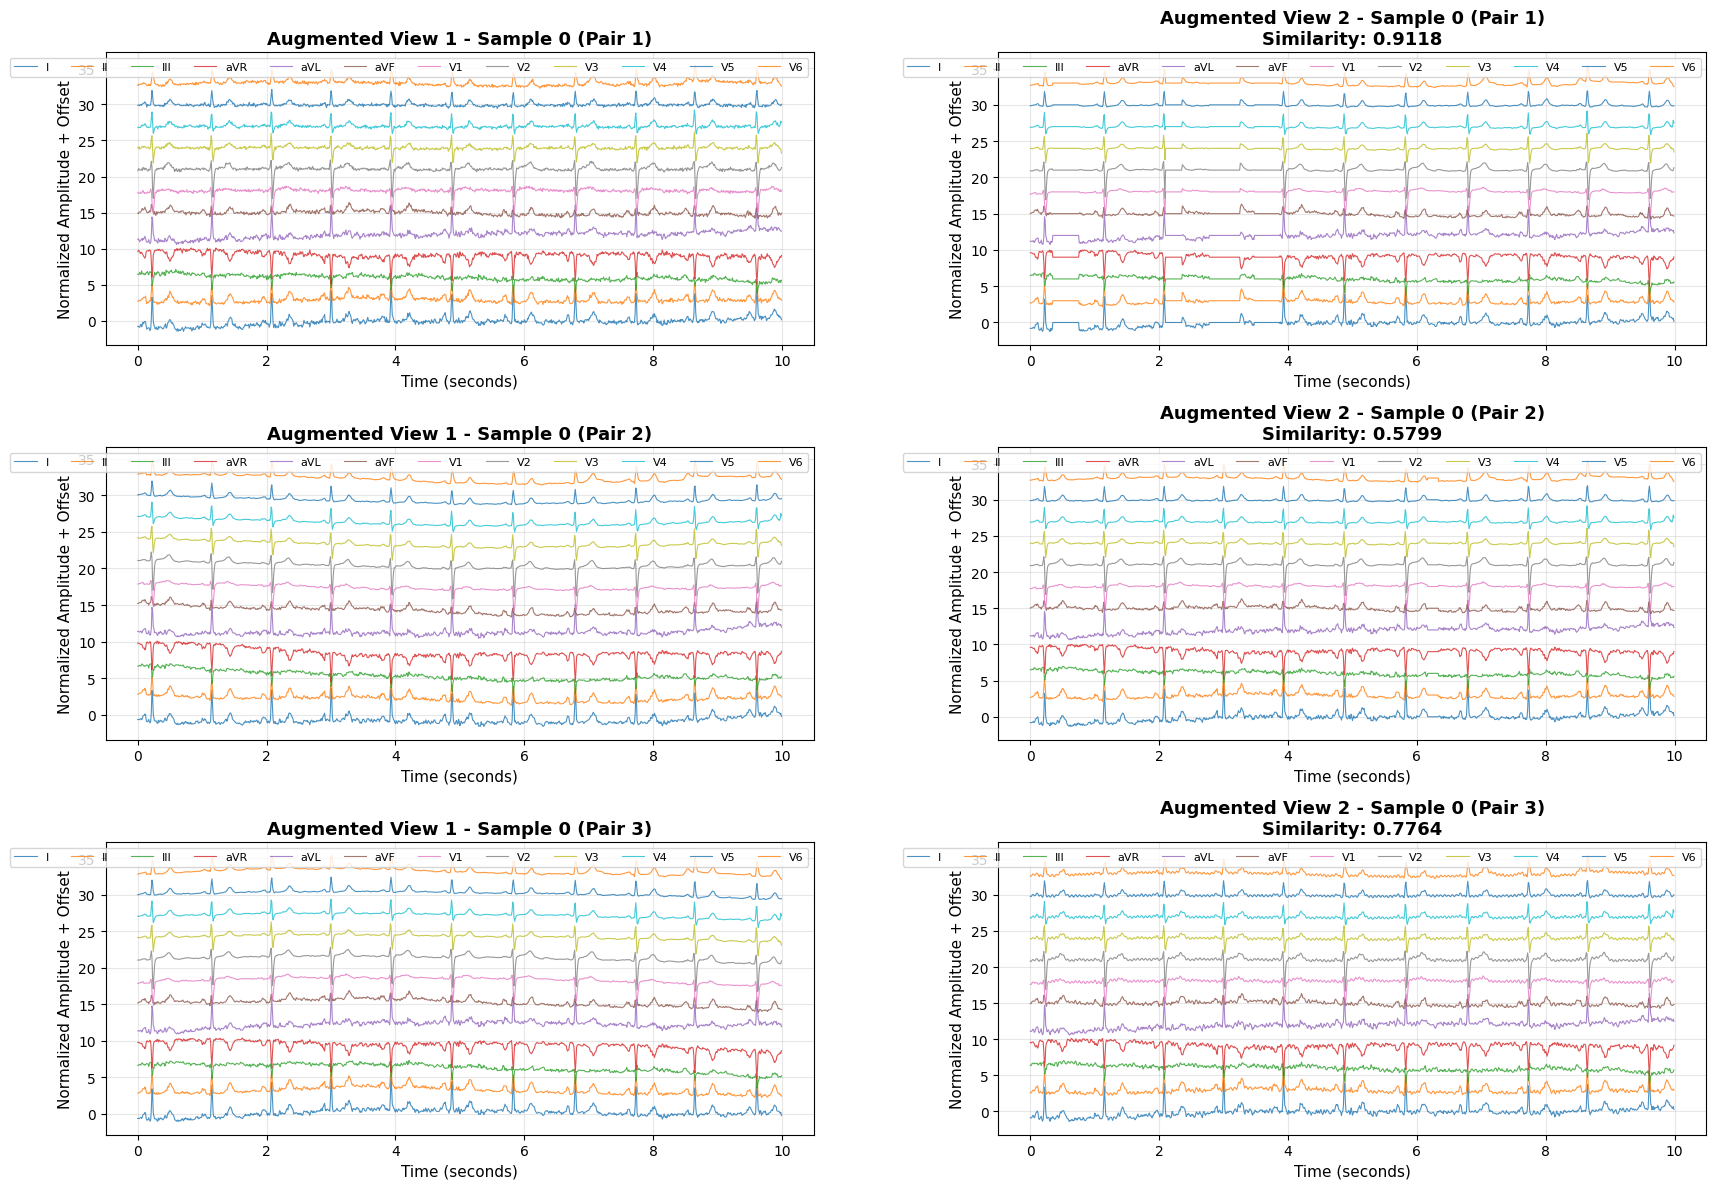


✓ Augmentation creates controlled diversity:
  Min similarity threshold: 0.35
  Max similarity threshold: 0.8
  This ensures views are similar but not identical for effective contrastive learning.


In [20]:
from scipy.spatial.distance import cosine

# Select one sample to show augmentations
sample_idx = 0
n_views = 3  # Show 3 different augmentation pairs

fig, axes = plt.subplots(n_views, 2, figsize=(18, 4 * n_views))

for view_idx in range(n_views):
    # Get augmented views from contrastive dataset (time_steps, num_channels)
    aug1, aug2 = train_dataset[sample_idx]
    aug1_np = aug1.numpy()
    aug2_np = aug2.numpy()
    
    if view_idx == 0:
        print(f"Augmented tensor shape (time, channels): {aug1_np.shape}")
    
    # Calculate similarity between the two views
    similarity = 1 - cosine(aug1_np.flatten(), aug2_np.flatten())
    
    time_axis = np.arange(aug1_np.shape[0]) / SAMPLING_RATE
    
    # Plot first augmented view
    ax1 = axes[view_idx, 0]
    for lead_idx in range(12):
        offset = lead_idx * 3
        ax1.plot(time_axis, aug1_np[:, lead_idx] + offset, 
                label=lead_names[lead_idx], linewidth=0.8, alpha=0.8)
    
    ax1.set_xlabel('Time (seconds)', fontsize=11)
    ax1.set_ylabel('Normalized Amplitude + Offset', fontsize=11)
    ax1.set_title(f'Augmented View 1 - Sample {sample_idx} (Pair {view_idx + 1})', 
                 fontsize=13, fontweight='bold')
    ax1.legend(ncol=12, loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Plot second augmented view
    ax2 = axes[view_idx, 1]
    for lead_idx in range(12):
        offset = lead_idx * 3
        ax2.plot(time_axis, aug2_np[:, lead_idx] + offset, 
                label=lead_names[lead_idx], linewidth=0.8, alpha=0.8)
    
    ax2.set_xlabel('Time (seconds)', fontsize=11)
    ax2.set_ylabel('Normalized Amplitude + Offset', fontsize=11)
    ax2.set_title(f'Augmented View 2 - Sample {sample_idx} (Pair {view_idx + 1})\nSimilarity: {similarity:.4f}', 
                 fontsize=13, fontweight='bold')
    ax2.legend(ncol=12, loc='upper right', fontsize=8)
    ax2.grid(True, alpha=0.3)
    
    print(f"Pair {view_idx + 1} - Cosine Similarity: {similarity:.4f}")
    print(f"  Within target range [{dual_augmenter.min_similarity}, {dual_augmenter.max_similarity}]? "
          f"{dual_augmenter.min_similarity <= similarity <= dual_augmenter.max_similarity}")

plt.tight_layout()
plt.show()

print(f"\n✓ Augmentation creates controlled diversity:")
print(f"  Min similarity threshold: {dual_augmenter.min_similarity}")
print(f"  Max similarity threshold: {dual_augmenter.max_similarity}")
print(f"  This ensures views are similar but not identical for effective contrastive learning.")

## Visualization: Side-by-Side Comparison

Let's create a comprehensive comparison showing raw, preprocessed, and augmented versions of the same signal,
keeping the `(time_steps, channels)` orientation consistent at every stage.

Side-by-side tensor shapes (time, channels): raw=(1000, 12), preprocessed=(1000, 12), aug=(1000, 12)


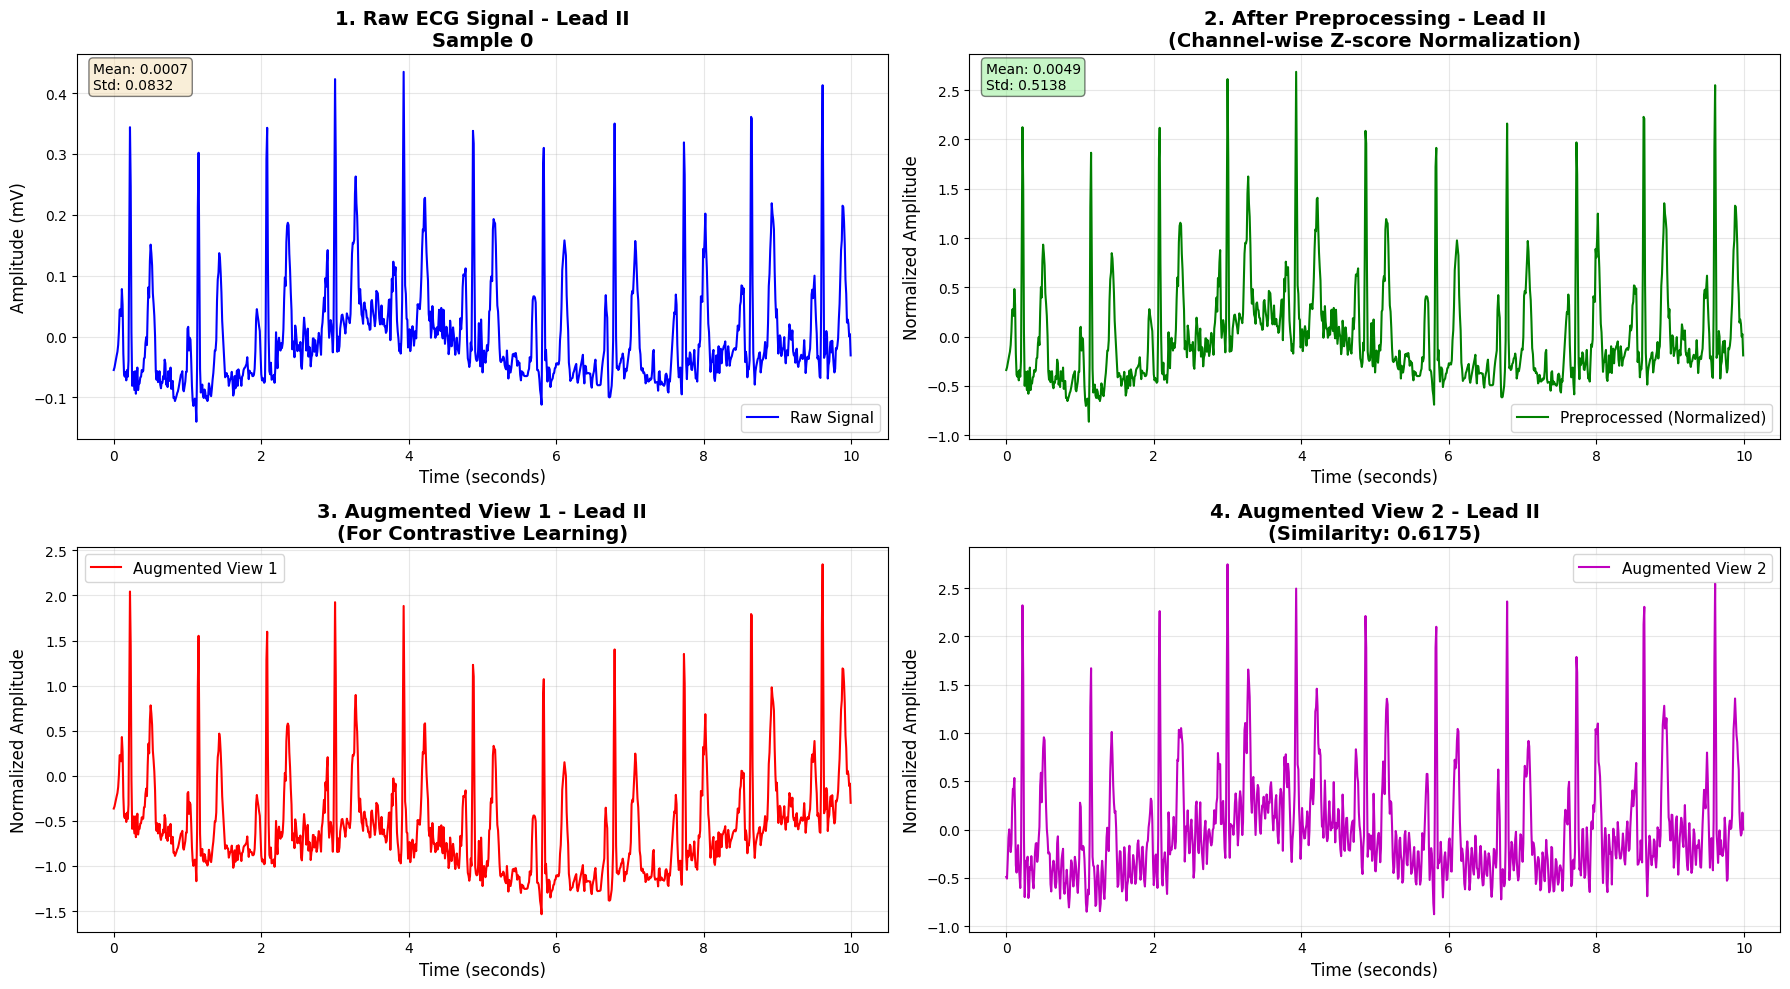

DATA PREPROCESSING PIPELINE SUMMARY

1. RAW DATA:
   - Shape (time, channels): (1000,)
   - Range: [-0.1400, 0.4350]
   - Mean: 0.0007, Std: 0.0832

2. AFTER PREPROCESSING (Normalization):
   - Channel-wise Z-score normalization: (x - mean) / std
   - Shape (time, channels): (1000,)
   - Range: [-0.8639, 2.6859]
   - Mean: 0.004885, Std: 0.5138

3. AFTER AUGMENTATION:
   - Applied random augmentations from pool: TimeShift, GaussNoise, PowerlineNoise,
     RespirationNoise, AmplitudeScale, TimeCutout
   - Two views created with controlled similarity: [0.35, 0.8]
   - Actual similarity: 0.6175
   - View 1 range: [-1.5352, 2.3453]
   - View 2 range: [-0.8758, 2.7470]



In [21]:
# Pick a sample and show one lead for clarity
sample_idx = 0
lead_idx = 1  # Lead II (commonly used in ECG analysis)

# Get the data at different stages
raw_signal = X_train_filtered[sample_idx][:, lead_idx]
preprocessed_signal, _ = train_dataset_classification[sample_idx]
preprocessed_np = preprocessed_signal.numpy()
aug1, aug2 = train_dataset[sample_idx]
aug1_np = aug1.numpy()
aug2_np = aug2.numpy()

print(f"Side-by-side tensor shapes (time, channels): raw={X_train_filtered[sample_idx].shape}, preprocessed={preprocessed_np.shape}, aug={aug1_np.shape}")

preprocessed_signal = preprocessed_np[:, lead_idx]
aug1_signal = aug1_np[:, lead_idx]
aug2_signal = aug2_np[:, lead_idx]

time_axis = np.arange(len(raw_signal)) / SAMPLING_RATE

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Raw signal
axes[0, 0].plot(time_axis, raw_signal, 'b-', linewidth=1.5, label='Raw Signal')
axes[0, 0].set_xlabel('Time (seconds)', fontsize=12)
axes[0, 0].set_ylabel('Amplitude (mV)', fontsize=12)
axes[0, 0].set_title(f'1. Raw ECG Signal - Lead {lead_names[lead_idx]}\nSample {sample_idx}', 
                     fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].text(0.02, 0.98, f'Mean: {raw_signal.mean():.4f}\nStd: {raw_signal.std():.4f}',
                transform=axes[0, 0].transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Preprocessed signal
axes[0, 1].plot(time_axis, preprocessed_signal, 'g-', linewidth=1.5, label='Preprocessed (Normalized)')
axes[0, 1].set_xlabel('Time (seconds)', fontsize=12)
axes[0, 1].set_ylabel('Normalized Amplitude', fontsize=12)
axes[0, 1].set_title(f'2. After Preprocessing - Lead {lead_names[lead_idx]}\n(Channel-wise Z-score Normalization)', 
                     fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].text(0.02, 0.98, f'Mean: {preprocessed_signal.mean():.4f}\nStd: {preprocessed_signal.std():.4f}',
                transform=axes[0, 1].transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

# Augmented view 1
axes[1, 0].plot(time_axis, aug1_signal, 'r-', linewidth=1.5, label='Augmented View 1')
axes[1, 0].set_xlabel('Time (seconds)', fontsize=12)
axes[1, 0].set_ylabel('Normalized Amplitude', fontsize=12)
axes[1, 0].set_title(f'3. Augmented View 1 - Lead {lead_names[lead_idx]}\n(For Contrastive Learning)', 
                     fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Augmented view 2
axes[1, 1].plot(time_axis, aug2_signal, 'm-', linewidth=1.5, label='Augmented View 2')
axes[1, 1].set_xlabel('Time (seconds)', fontsize=12)
axes[1, 1].set_ylabel('Normalized Amplitude', fontsize=12)
similarity = 1 - cosine(aug1_np.flatten(), aug2_np.flatten())
axes[1, 1].set_title(f'4. Augmented View 2 - Lead {lead_names[lead_idx]}\n(Similarity: {similarity:.4f})', 
                     fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 80)
print("DATA PREPROCESSING PIPELINE SUMMARY")
print("=" * 80)
print(f"\n1. RAW DATA:")
print(f"   - Shape (time, channels): {raw_signal.shape}")
print(f"   - Range: [{raw_signal.min():.4f}, {raw_signal.max():.4f}]")
print(f"   - Mean: {raw_signal.mean():.4f}, Std: {raw_signal.std():.4f}")

print(f"\n2. AFTER PREPROCESSING (Normalization):")
print(f"   - Channel-wise Z-score normalization: (x - mean) / std")
print(f"   - Shape (time, channels): {preprocessed_signal.shape}")
print(f"   - Range: [{preprocessed_signal.min():.4f}, {preprocessed_signal.max():.4f}]")
print(f"   - Mean: {preprocessed_signal.mean():.6f}, Std: {preprocessed_signal.std():.4f}")

print(f"\n3. AFTER AUGMENTATION:")
print(f"   - Applied random augmentations from pool: TimeShift, GaussNoise, PowerlineNoise,")
print(f"     RespirationNoise, AmplitudeScale, TimeCutout")
print(f"   - Two views created with controlled similarity: [{dual_augmenter.min_similarity}, {dual_augmenter.max_similarity}]")
print(f"   - Actual similarity: {similarity:.4f}")
print(f"   - View 1 range: [{aug1_signal.min():.4f}, {aug1_signal.max():.4f}]")
print(f"   - View 2 range: [{aug2_signal.min():.4f}, {aug2_signal.max():.4f}]")

print("\n" + "=" * 80)

# Evaluation Pipeline
We will plot the test-set in 2-d using PCA and add the labels as the colors.

In [22]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np


def extract_embeddings(model, dataloader, device=None):
    """
    Extract embeddings and labels from the model for a given dataset.
    
    Args:
        model: Trained ECGEncoder
        dataloader: DataLoader with (signal, label) pairs
        device: Device to run inference on
        
    Returns:
        embeddings: numpy array of shape (n_samples, d_model)
        labels: numpy array of integer labels
    """
    if device is None:
        device = next(model.parameters()).device
    
    model.eval()
    all_embeddings = []
    all_labels = []
    
    with torch.no_grad():
        for signals, labels in dataloader:
            signals = signals.to(device)
            representations, _ = model(signals)  # Use representations, not projections
            all_embeddings.append(representations.to(torch.float32).cpu().numpy())
            # Labels are already integers from ECGDataset
            all_labels.extend(labels.cpu().numpy() if torch.is_tensor(labels) else labels)
    
    embeddings = np.concatenate(all_embeddings, axis=0)
    labels_array = np.array(all_labels, dtype=int)
    return embeddings, labels_array


def plot_embeddings_2d(embeddings, labels, method='pca', title='ECG Embeddings Visualization', 
                        figsize=(12, 8), label_names=None):
    """
    Plot embeddings in 2D using PCA or t-SNE.
    
    Args:
        embeddings: numpy array of shape (n_samples, d_model)
        labels: numpy array of integer labels for each sample
        method: 'pca' or 'tsne'
        title: Plot title
        figsize: Figure size
        label_names: Optional dict mapping integer labels to class names (e.g., {0: 'Normal', 1: 'AF', ...})
    """
    # Ensure labels are numpy array
    if not isinstance(labels, np.ndarray):
        labels = np.array(labels, dtype=int)
    
    # Reduce to 2D
    if method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        embeddings_2d = reducer.fit_transform(embeddings)
        explained_var = reducer.explained_variance_ratio_
        subtitle = f'Explained variance: {explained_var[0]:.2%} (PC1), {explained_var[1]:.2%} (PC2)'
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        embeddings_2d = reducer.fit_transform(embeddings)
        subtitle = 't-SNE projection'
    else:
        raise ValueError("method must be 'pca' or 'tsne'")
    
    # Get unique labels
    unique_labels = np.unique(labels)
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    scatter = ax.scatter(
        embeddings_2d[:, 0], 
        embeddings_2d[:, 1], 
        c=labels, 
        cmap='tab10', 
        alpha=0.6,
        s=20
    )
    
    # Add legend with optional label names
    if label_names is not None:
        handles = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=scatter.cmap(scatter.norm(label)), 
                              markersize=8, label=label_names.get(label, f'Class {label}')) 
                   for label in unique_labels]
    else:
        handles = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=scatter.cmap(scatter.norm(label)), 
                              markersize=8, label=f'Class {label}') 
                   for label in unique_labels]
    
    ax.legend(handles=handles, title='Diagnostic Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_title(f'{title}\n{subtitle}')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return embeddings_2d, unique_labels


def calculate_clustering_metrics(embeddings, labels):
    """
    Calculate clustering quality metrics.
    
    Args:
        embeddings: numpy array of shape (n_samples, d_model)
        labels: numpy array of integer labels
    
    Returns:
        Dictionary with clustering metrics
    """
    # Ensure labels are numpy array of integers
    if not isinstance(labels, np.ndarray):
        labels = np.array(labels, dtype=int)
    
    # Get unique labels and their counts
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    # Calculate metrics
    metrics = {
        'silhouette_score': silhouette_score(embeddings, labels),
        'davies_bouldin_score': davies_bouldin_score(embeddings, labels),
        'calinski_harabasz_score': calinski_harabasz_score(embeddings, labels),
        'n_samples': len(labels),
        'n_classes': len(unique_labels),
        'class_distribution': {int(label): int(count) for label, count in zip(unique_labels, counts)}
    }
    
    return metrics


def print_clustering_metrics(metrics, label_names=None):
    """
    Pretty print clustering metrics.
    
    Args:
        metrics: Dictionary of clustering metrics from calculate_clustering_metrics
        label_names: Optional dict mapping integer labels to class names (e.g., {0: 'Normal', 1: 'AF', ...})
    """
    print("=" * 60)
    print("CLUSTERING QUALITY METRICS")
    print("=" * 60)
    print(f"Number of samples: {metrics['n_samples']}")
    print(f"Number of classes: {metrics['n_classes']}")
    print()
    print("Metrics:")
    print(f"  Silhouette Score:        {metrics['silhouette_score']:.4f}")
    print(f"    (Range: [-1, 1], Higher is better)")
    print(f"    > 0.5: Strong separation")
    print(f"    > 0.3: Reasonable separation")
    print()
    print(f"  Davies-Bouldin Score:    {metrics['davies_bouldin_score']:.4f}")
    print(f"    (Range: [0, ∞], Lower is better)")
    print(f"    < 1.0: Good clustering")
    print()
    print(f"  Calinski-Harabasz Score: {metrics['calinski_harabasz_score']:.2f}")
    print(f"    (Range: [0, ∞], Higher is better)")
    print()
    print("Class Distribution:")
    for label, count in sorted(metrics['class_distribution'].items(), key=lambda x: x[1], reverse=True):
        percentage = (count / metrics['n_samples']) * 100
        if label_names is not None:
            label_str = label_names.get(label, f'Class {label}')
        else:
            label_str = f'Class {label}'
        print(f"  {label_str:20s}: {count:4d} samples ({percentage:5.1f}%)")
    print("=" * 60)


# Our Architecture

Try next:
1. Replacing Sinosudial Positional Encoding with learnable weights.
2. Set-wise Channel-wise Normalization.
3. Mix of both.

In [23]:
from src import ECGModelConfig, ECGEncoder

In [24]:
from typing import Tuple


def summarize_encoder_params(model) -> Tuple[int, int]:
    """
    Print a concise summary of the encoder's parameters and return (total, trainable).
    Uses existing `ecg_encoder`, `encoder_config`, `total_params`, `trainable_params` if available.
    """
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Model: {model.__class__.__name__}")
    print(f"Total params:     {total:,}")
    print(f"Trainable params: {trainable:,}\n")

    print("Per top-level module parameter counts:")
    for name, module in model.named_children():
        mod_total = sum(p.numel() for p in module.parameters())
        mod_train = sum(p.numel() for p in module.parameters() if p.requires_grad)
        print(f"  {name:20s} | total: {mod_total:10,} | trainable: {mod_train:10,}")

    return total, trainable


ecg_encoder = ECGEncoder(ECGModelConfig(sequence_length=1000,
    positional_embedding_length=1000,
    num_channels=12,
    d_model=512,
    channel_token_length=256,
    time_heads=4,
    channel_heads=4,
    time_layers=6,
    channel_layers=4,
    ff_multiplier=4,
    dropout=0.05,
    temperature=0.5,
    projection_dim=512,
    dtype=torch.bfloat16))

# Use the existing ecg_encoder variable in the notebook
total, trainable = summarize_encoder_params(ecg_encoder)

Model: ECGEncoder
Total params:     35,330,992
Trainable params: 35,330,992

Per top-level module parameter counts:
  time_encoder         | total: 19,432,960 | trainable: 19,432,960
  channel_encoder      | total: 12,742,576 | trainable: 12,742,576
  cross_attention      | total:  2,103,296 | trainable:  2,103,296
  fusion               | total:    525,824 | trainable:    525,824
  projection           | total:    526,336 | trainable:    526,336


## Training

Epoch 1/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=5.2188]


Epoch [1/25] Train Loss: 6.1562 | Grad Norm: 1.00 | LR: 0.000200 | Val Loss: 5.2188 | Time: 9.1s | Total: 9.1s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_1.pt
New best model saved with loss: 6.1562
Removed old checkpoint: checkpoint_epoch_1.pt


Epoch 2/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=4.9375]


Epoch [2/25] Train Loss: 5.7812 | Grad Norm: 4.16 | LR: 0.000200 | Val Loss: 4.9375 | Time: 7.3s | Total: 18.1s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_2.pt
New best model saved with loss: 5.7812
Removed old checkpoint: checkpoint_epoch_2.pt


Epoch 3/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s, val_loss=4.6875]


Epoch [3/25] Train Loss: 5.4375 | Grad Norm: 2.84 | LR: 0.000200 | Val Loss: 4.6875 | Time: 7.3s | Total: 27.3s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_3.pt
New best model saved with loss: 5.4375
Removed old checkpoint: checkpoint_epoch_3.pt


Epoch 4/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s, val_loss=4.5312]


Epoch [4/25] Train Loss: 5.2344 | Grad Norm: 2.37 | LR: 0.000200 | Val Loss: 4.5312 | Time: 7.3s | Total: 36.5s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_4.pt
New best model saved with loss: 5.2344
Removed old checkpoint: checkpoint_epoch_4.pt


Epoch 5/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=4.5312]


Epoch [5/25] Train Loss: 5.1094 | Grad Norm: 2.14 | LR: 0.000200 | Val Loss: 4.5312 | Time: 7.3s | Total: 45.8s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_5.pt
New best model saved with loss: 5.1094
Removed old checkpoint: checkpoint_epoch_5.pt


Epoch 6/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s, val_loss=4.4688]


Epoch [6/25] Train Loss: 5.1250 | Grad Norm: 3.75 | LR: 0.000200 | Val Loss: 4.4688 | Time: 7.3s | Total: 54.9s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_6.pt
Removed old checkpoint: checkpoint_epoch_6.pt


Epoch 7/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s, val_loss=4.4062]


Epoch [7/25] Train Loss: 5.0625 | Grad Norm: 2.74 | LR: 0.000200 | Val Loss: 4.4062 | Time: 7.4s | Total: 63.6s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_7.pt
New best model saved with loss: 5.0625
Removed old checkpoint: checkpoint_epoch_7.pt


Epoch 8/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s, val_loss=4.3438]


Epoch [8/25] Train Loss: 5.0156 | Grad Norm: 1.94 | LR: 0.000200 | Val Loss: 4.3438 | Time: 7.4s | Total: 72.8s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_8.pt
New best model saved with loss: 5.0156
Removed old checkpoint: checkpoint_epoch_8.pt


Epoch 9/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=4.3125]


Epoch [9/25] Train Loss: 4.9531 | Grad Norm: 1.33 | LR: 0.000200 | Val Loss: 4.3125 | Time: 7.4s | Total: 82.0s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_9.pt
New best model saved with loss: 4.9531
Removed old checkpoint: checkpoint_epoch_9.pt


Epoch 10/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s, val_loss=4.2812]


Epoch [10/25] Train Loss: 4.9062 | Grad Norm: 1.20 | LR: 0.000200 | Val Loss: 4.2812 | Time: 7.4s | Total: 91.3s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_10.pt
New best model saved with loss: 4.9062
Removed old checkpoint: checkpoint_epoch_10.pt


Epoch 11/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s, val_loss=4.2812]


Epoch [11/25] Train Loss: 4.8906 | Grad Norm: 1.19 | LR: 0.000200 | Val Loss: 4.2812 | Time: 7.4s | Total: 100.5s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_11.pt
New best model saved with loss: 4.8906
Removed old checkpoint: checkpoint_epoch_11.pt


Epoch 12/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s, val_loss=4.2500]


Epoch [12/25] Train Loss: 4.8906 | Grad Norm: 1.72 | LR: 0.000200 | Val Loss: 4.2500 | Time: 7.4s | Total: 109.7s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_12.pt
Removed old checkpoint: checkpoint_epoch_12.pt


Epoch 13/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s, val_loss=4.2500]


Epoch [13/25] Train Loss: 4.8750 | Grad Norm: 1.17 | LR: 0.000200 | Val Loss: 4.2500 | Time: 7.4s | Total: 118.7s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_13.pt
New best model saved with loss: 4.8750
Removed old checkpoint: checkpoint_epoch_13.pt


Epoch 14/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s, val_loss=4.2500]


Epoch [14/25] Train Loss: 4.8594 | Grad Norm: 1.18 | LR: 0.000200 | Val Loss: 4.2500 | Time: 7.4s | Total: 127.9s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_14.pt
New best model saved with loss: 4.8594
Removed old checkpoint: checkpoint_epoch_14.pt


Epoch 15/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s, val_loss=4.2188]


Epoch [15/25] Train Loss: 4.8438 | Grad Norm: 1.30 | LR: 0.000200 | Val Loss: 4.2188 | Time: 7.4s | Total: 137.1s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_15.pt
New best model saved with loss: 4.8438
Removed old checkpoint: checkpoint_epoch_15.pt


Epoch 16/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s, val_loss=4.2188]


Epoch [16/25] Train Loss: 4.8438 | Grad Norm: 0.77 | LR: 0.000080 | Val Loss: 4.2188 | Time: 7.4s | Total: 146.2s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_16.pt
Removed old checkpoint: checkpoint_epoch_16.pt


Epoch 17/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s, val_loss=4.2188]


Epoch [17/25] Train Loss: 4.8281 | Grad Norm: 0.61 | LR: 0.000080 | Val Loss: 4.2188 | Time: 7.4s | Total: 155.0s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_17.pt
New best model saved with loss: 4.8281
Removed old checkpoint: checkpoint_epoch_17.pt


Epoch 18/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s, val_loss=4.1875]


Epoch [18/25] Train Loss: 4.8281 | Grad Norm: 0.56 | LR: 0.000080 | Val Loss: 4.1875 | Time: 7.4s | Total: 164.2s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_18.pt
Removed old checkpoint: checkpoint_epoch_18.pt


Epoch 19/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s, val_loss=4.2188]


Epoch [19/25] Train Loss: 4.8281 | Grad Norm: 0.72 | LR: 0.000080 | Val Loss: 4.2188 | Time: 7.4s | Total: 173.0s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_19.pt
Removed old checkpoint: checkpoint_epoch_19.pt


Epoch 20/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s, val_loss=4.2188]


Epoch [20/25] Train Loss: 4.8125 | Grad Norm: 0.67 | LR: 0.000080 | Val Loss: 4.2188 | Time: 7.4s | Total: 181.7s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_20.pt
New best model saved with loss: 4.8125
Removed old checkpoint: checkpoint_epoch_20.pt


Epoch 21/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s, val_loss=4.2188]


Epoch [21/25] Train Loss: 4.8125 | Grad Norm: 0.66 | LR: 0.000080 | Val Loss: 4.2188 | Time: 7.4s | Total: 190.9s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_21.pt
Removed old checkpoint: checkpoint_epoch_21.pt


Epoch 22/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s, val_loss=4.2188]


Epoch [22/25] Train Loss: 4.8125 | Grad Norm: 0.56 | LR: 0.000080 | Val Loss: 4.2188 | Time: 7.4s | Total: 199.5s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_22.pt
Removed old checkpoint: checkpoint_epoch_22.pt


Epoch 23/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s, val_loss=4.1875]


Epoch [23/25] Train Loss: 4.8125 | Grad Norm: 0.46 | LR: 0.000080 | Val Loss: 4.1875 | Time: 7.4s | Total: 208.2s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_23.pt
Removed old checkpoint: checkpoint_epoch_23.pt


Epoch 24/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s, val_loss=4.1875]


Epoch [24/25] Train Loss: 4.8125 | Grad Norm: 0.49 | LR: 0.000080 | Val Loss: 4.1875 | Time: 7.5s | Total: 217.1s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_24.pt
Removed old checkpoint: checkpoint_epoch_24.pt


Epoch 25/25 [Val]: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s, val_loss=4.1875]


Epoch [25/25] Train Loss: 4.7969 | Grad Norm: 0.50 | LR: 0.000080 | Val Loss: 4.1875 | Time: 7.4s | Total: 225.9s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_25.pt
New best model saved with loss: 4.7969
Removed old checkpoint: checkpoint_epoch_25.pt

Training completed in 228.0s (3.8 minutes)


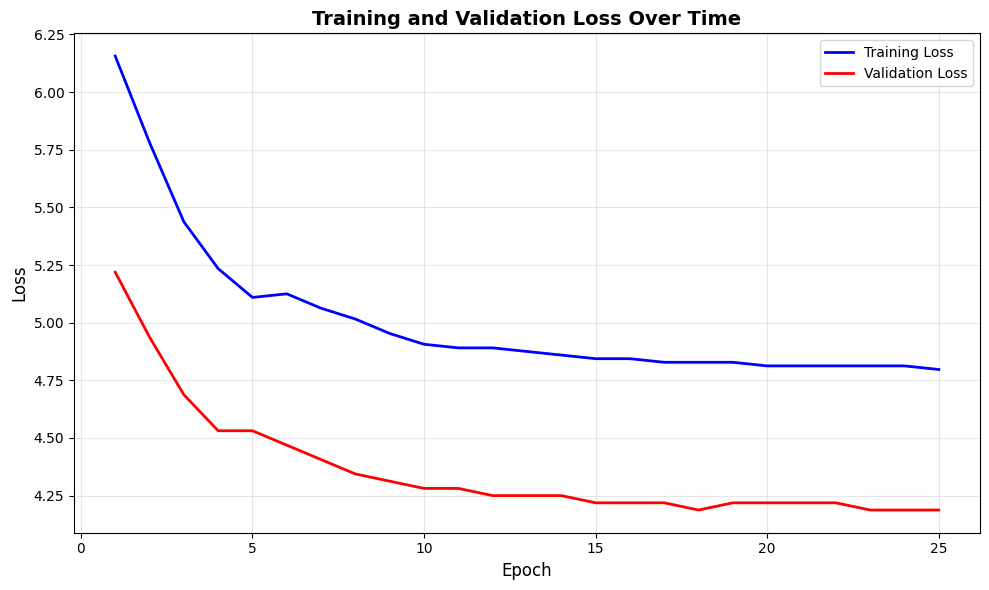


Final Training Loss: 4.7969
Final Validation Loss: 4.1875
Best Validation Loss: 4.1875 (Epoch 18)


In [35]:
import matplotlib.pyplot as plt
from torch.utils.data import Subset
train_dataset = Subset(ECGContrastiveTrainDataset(
    X=X_train_filtered, 
    y=y_train_int, 
    dual_augmenter=dual_augmenter
), indices=np.random.randint(0, len(X_train_filtered), size=500))

model = ECGEncoder(ECGModelConfig(sequence_length=1000,
    positional_embedding_length=1000,
    num_channels=12,
    d_model=512,
    channel_token_length=256,
    time_heads=4,
    channel_heads=4,
    time_layers=6,
    channel_layers=4,
    ff_multiplier=4,
    dropout=0.05,
    temperature=0.5,
    projection_dim=512,
    dtype=torch.bfloat16))

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
loss_fn = NTXentLoss(temperature=0.65)

simple_history = train(
    model=model,
    dataset=train_dataset,
    optimizer=optimizer,
    loss_fn=loss_fn,
    config=ECGModelConfig(),
    batch_size=256,
    epochs=25,
    checkpoint_manager=CheckpointManager(
        checkpoint_dir="../models/checkpoints",
        keep_last_n=2,
        save_best=True
    ),
    resume_from=None,
    val_dataset=val_dataset,
)


plt.figure(figsize=(10, 6))
epochs_range = range(1, len(simple_history['loss_history']) + 1)
plt.plot(epochs_range, simple_history['loss_history'], 'b-', label='Training Loss', linewidth=2)
if 'val_loss_history' in simple_history and simple_history['val_loss_history']:
    plt.plot(epochs_range, simple_history['val_loss_history'], 'r-', label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss Over Time', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Training Loss: {simple_history['loss_history'][-1]:.4f}")
if 'val_loss_history' in simple_history and simple_history['val_loss_history']:
    print(f"Final Validation Loss: {simple_history['val_loss_history'][-1]:.4f}")
    print(f"Best Validation Loss: {min(simple_history['val_loss_history']):.4f} (Epoch {simple_history['val_loss_history'].index(min(simple_history['val_loss_history'])) + 1})")

## Evaluation

In [36]:
Y_test_superclasses_dense = Y_test_superclasses.argmax(axis=1)

In [37]:
# Extract embeddings from the test set
print("Extracting embeddings from test set...")
test_dataset = ECGDataset(
    X=X_test_filtered,
    y=Y_test_superclasses_dense,
)
train_eval_dataset = ECGDataset(
    X=X_train_filtered,
    y=y_train_int,
)
test_loader = DataLoader(train_eval_dataset, batch_size=128, shuffle=False)
embeddings, labels = extract_embeddings(model, test_loader)
print(f"Extracted {len(embeddings)} embeddings with dimension {embeddings.shape[1]}")
print(f"Found {len(set(labels))} unique classes: {sorted(set(labels))}")

Extracting embeddings from test set...
Extracted 879 embeddings with dimension 512
Found 5 unique classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]


In [38]:
# Calculate and print clustering metrics
metrics = calculate_clustering_metrics(embeddings, labels)
print_clustering_metrics(metrics)

CLUSTERING QUALITY METRICS
Number of samples: 879
Number of classes: 5

Metrics:
  Silhouette Score:        -0.0217
    (Range: [-1, 1], Higher is better)
    > 0.5: Strong separation
    > 0.3: Reasonable separation

  Davies-Bouldin Score:    7.6751
    (Range: [0, ∞], Lower is better)
    < 1.0: Good clustering

  Calinski-Harabasz Score: 8.28
    (Range: [0, ∞], Higher is better)

Class Distribution:
  Class 3             :  589 samples ( 67.0%)
  Class 4             :  109 samples ( 12.4%)
  Class 0             :   84 samples (  9.6%)
  Class 2             :   68 samples (  7.7%)
  Class 1             :   29 samples (  3.3%)



Generating PCA visualization...


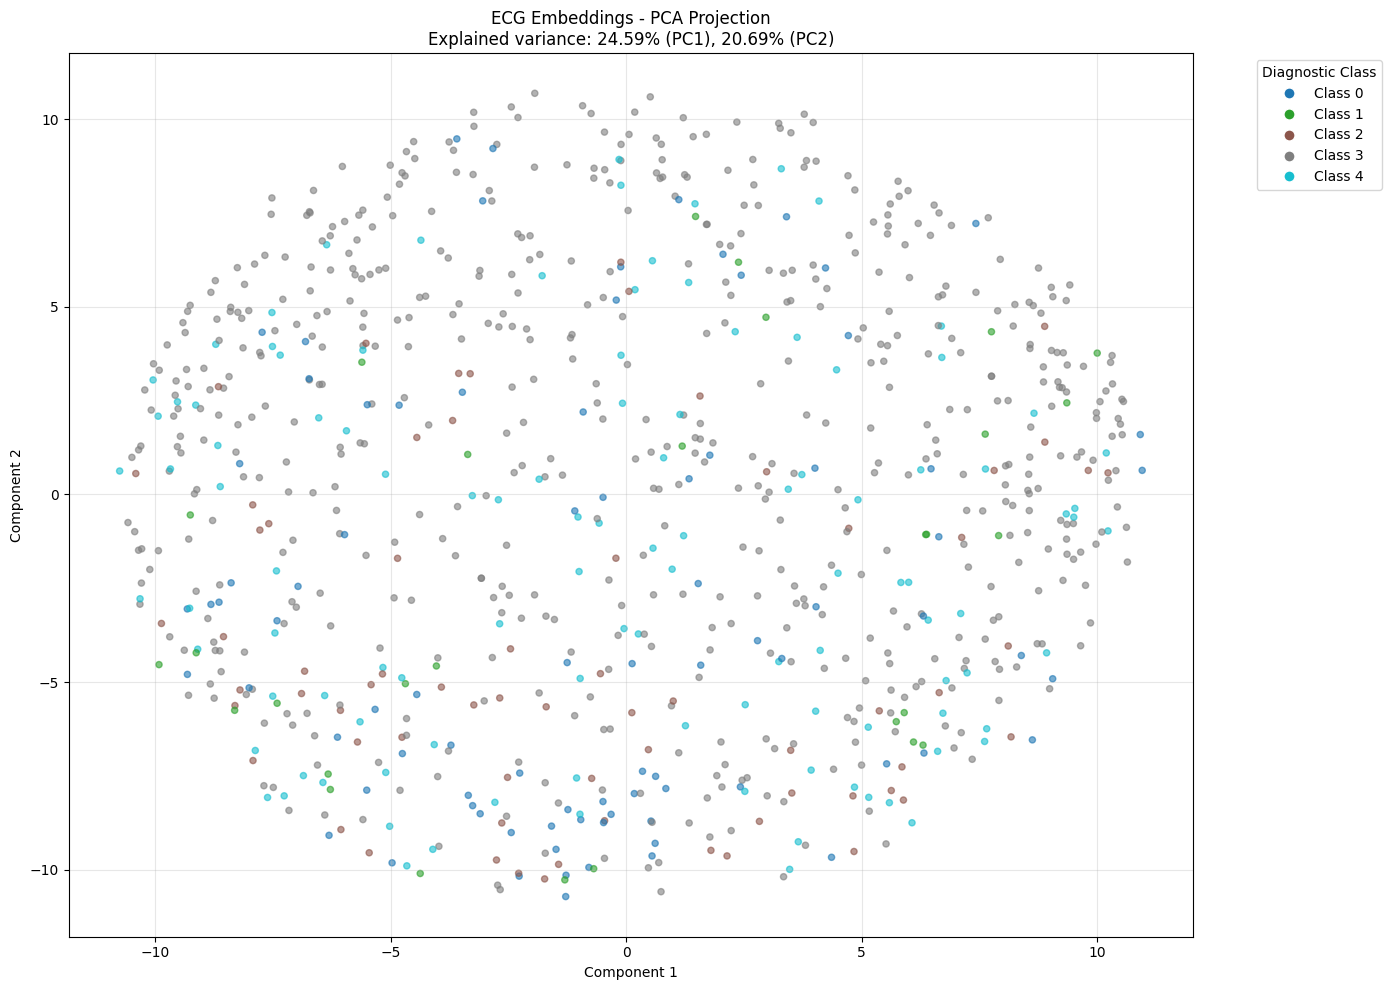

In [39]:
# Visualize embeddings with PCA
print("\nGenerating PCA visualization...")
embeddings_2d_pca, unique_labels = plot_embeddings_2d(
    embeddings, 
    labels, 
    method='pca', 
    title='ECG Embeddings - PCA Projection',
    figsize=(14, 10)
)


Generating t-SNE visualization...


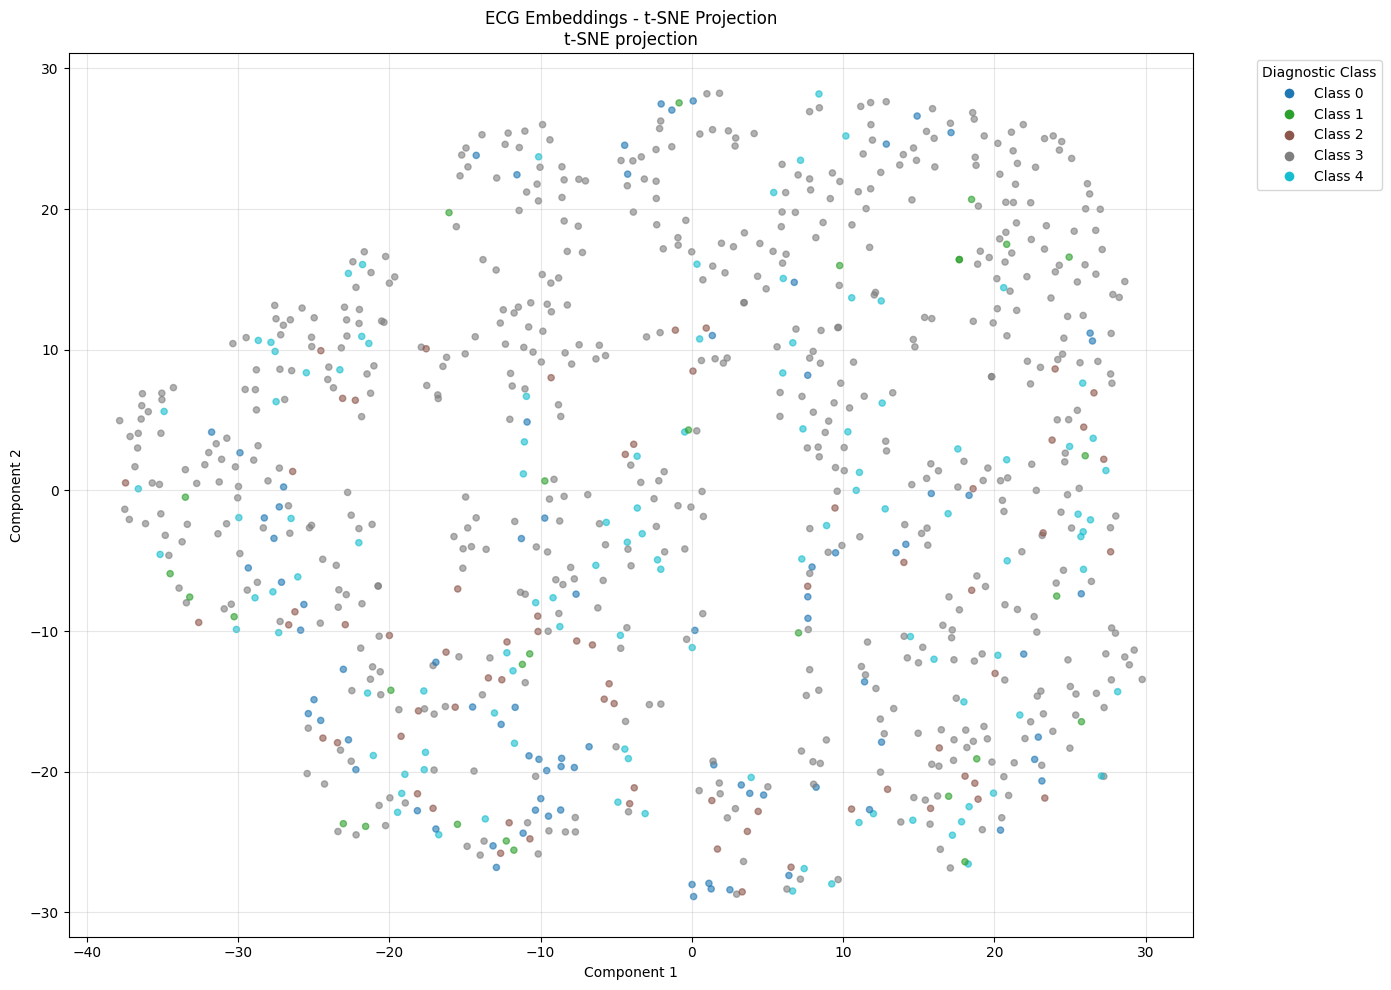

In [40]:
# Visualize embeddings with t-SNE (optional, takes longer)
print("\nGenerating t-SNE visualization...")
embeddings_2d_tsne, _ = plot_embeddings_2d(
    embeddings, 
    labels, 
    method='tsne', 
    title='ECG Embeddings - t-SNE Projection',
    figsize=(14, 10)
)

# Baseline Model: 1D ResNet for ECG

This is a simpler baseline model based on ResNet architecture, commonly used in time-series classification papers:
- **Paper**: "Deep Residual Learning for Image Recognition" (He et al., 2015)
- **Adapted for 1D signals**: Used in many ECG papers including "Cardiologist-level arrhythmia detection" (Rajpurkar et al., 2017)
- **Architecture**: ResNet-18 style with 1D convolutions
- **Benefits**: Proven architecture, easier to train, fewer parameters

## Model Architecture

In [ ]:
from src import SimpleECGEncoder, SimpleECGConfig

In [ ]:
# Initialize simple model with same training setup
simple_model = SimpleECGEncoder(SimpleECGConfig())
simple_optimizer = torch.optim.AdamW(simple_model.parameters(), lr=1e-4)  # Slightly higher LR for simpler model
simple_loss_fn = NTXentLoss(temperature=0.5)

# Train the baseline model
print("Training simple ResNet baseline model...")
print("=" * 80)

simple_history = train(
    model=simple_model,
    dataset=train_dataset,
    optimizer=simple_optimizer,
    loss_fn=simple_loss_fn,
    config=SimpleECGConfig(),
    batch_size=128,
    epochs=10,
    checkpoint_manager=CheckpointManager(
        checkpoint_dir="../models/checkpoints_simple",
        keep_last_n=2,
        save_best=True
    ),
    resume_from=None,
    val_dataset=val_dataset,
)

Training simple ResNet baseline model...


Epoch 1/5 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.49it/s, val_loss=2.9221]


Epoch [1/5] Train Loss: 3.6564 | Grad Norm: 2.55 | Val Loss: 3.5082 | Time: 17.9s | Total: 17.9s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_1.pt
New best model saved with loss: 3.6564
Removed old checkpoint: checkpoint_epoch_1.pt


Epoch 2/5 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.54it/s, val_loss=2.5806]


Epoch [2/5] Train Loss: 3.2626 | Grad Norm: 1.14 | Val Loss: 3.0898 | Time: 16.1s | Total: 43.4s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_2.pt
New best model saved with loss: 3.2626
Removed old checkpoint: checkpoint_epoch_2.pt


Epoch 3/5 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.61it/s, val_loss=2.4524]


Epoch [3/5] Train Loss: 3.1759 | Grad Norm: 0.94 | Val Loss: 2.9841 | Time: 16.2s | Total: 69.4s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_3.pt
New best model saved with loss: 3.1759
Removed old checkpoint: checkpoint_epoch_3.pt


Epoch 4/5 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.39it/s, val_loss=2.5072]


Epoch [4/5] Train Loss: 3.1162 | Grad Norm: 0.87 | Val Loss: 2.9963 | Time: 16.2s | Total: 95.2s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_4.pt
New best model saved with loss: 3.1162
Removed old checkpoint: checkpoint_epoch_4.pt


Epoch 5/5 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.13it/s, val_loss=2.4812]


Epoch [5/5] Train Loss: 3.0824 | Grad Norm: 0.81 | Val Loss: 2.9209 | Time: 16.3s | Total: 121.3s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_5.pt
New best model saved with loss: 3.0824
Removed old checkpoint: checkpoint_epoch_5.pt

Training completed in 131.1s (2.2 minutes)


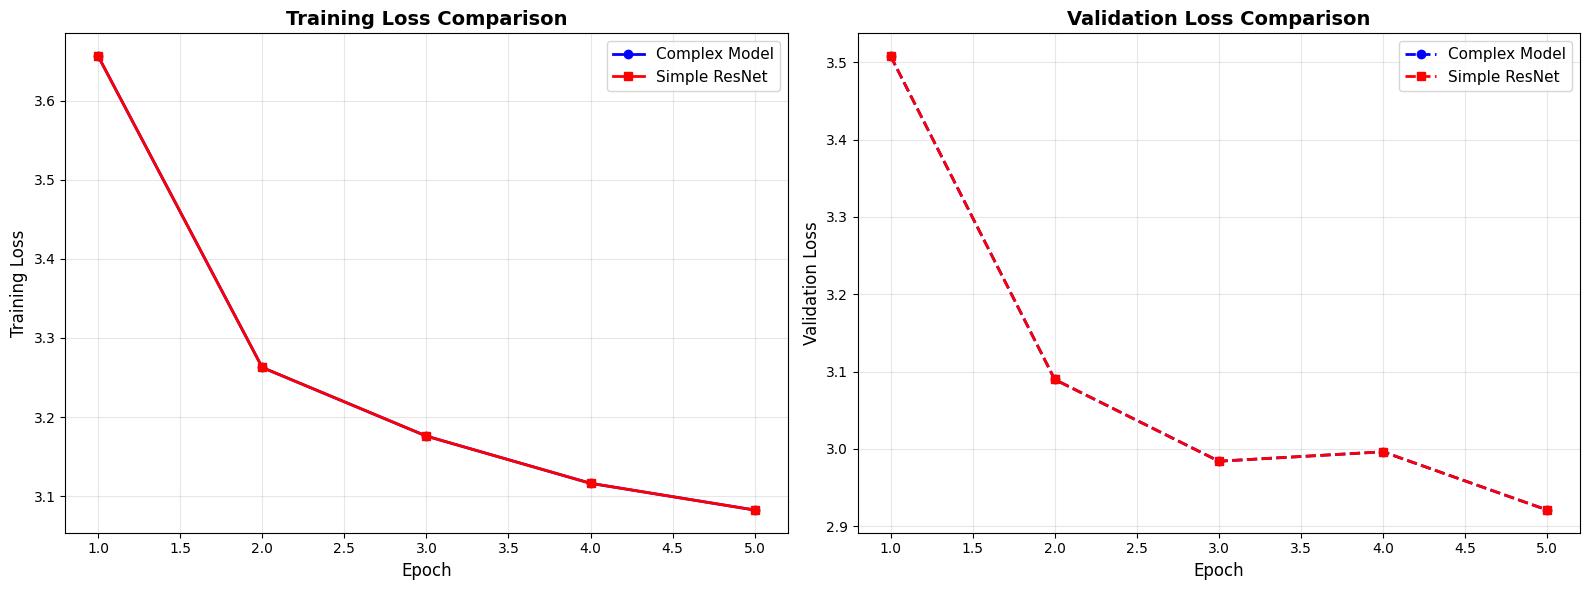


MODEL COMPARISON SUMMARY

Complex Transformer Model:
  Final Training Loss:   3.0824
  Final Validation Loss: 2.9209
  Best Validation Loss:  2.9209

Simple ResNet Baseline:
  Final Training Loss:   3.0824
  Final Validation Loss: 2.9209
  Best Validation Loss:  2.9209



In [ ]:
# Compare training curves: Complex vs Simple model
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training loss comparison
axes[0].plot(range(1, len(simple_history['loss_history']) + 1), 
             simple_history['loss_history'], 'b-', label='Complex Model', linewidth=2, marker='o')
axes[0].plot(range(1, len(simple_history['loss_history']) + 1), 
             simple_history['loss_history'], 'r-', label='Simple ResNet', linewidth=2, marker='s')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Training Loss', fontsize=12)
axes[0].set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Validation loss comparison
if 'val_loss_history' in simple_history and 'val_loss_history' in simple_history:
    axes[1].plot(range(1, len(simple_history['val_loss_history']) + 1), 
                 simple_history['val_loss_history'], 'b--', label='Complex Model', linewidth=2, marker='o')
    axes[1].plot(range(1, len(simple_history['val_loss_history']) + 1), 
                 simple_history['val_loss_history'], 'r--', label='Simple ResNet', linewidth=2, marker='s')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Validation Loss', fontsize=12)
    axes[1].set_title('Validation Loss Comparison', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison statistics
print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print("\nComplex Transformer Model:")
print(f"  Final Training Loss:   {simple_history['loss_history'][-1]:.4f}")
if 'val_loss_history' in simple_history:
    print(f"  Final Validation Loss: {simple_history['val_loss_history'][-1]:.4f}")
    print(f"  Best Validation Loss:  {min(simple_history['val_loss_history']):.4f}")

print("\nSimple ResNet Baseline:")
print(f"  Final Training Loss:   {simple_history['loss_history'][-1]:.4f}")
if 'val_loss_history' in simple_history:
    print(f"  Final Validation Loss: {simple_history['val_loss_history'][-1]:.4f}")
    print(f"  Best Validation Loss:  {min(simple_history['val_loss_history']):.4f}")

print("\n" + "=" * 80)

## Evaluate Simple Model Embeddings

Let's evaluate the quality of embeddings from the simple ResNet model and compare clustering metrics.

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Extract embeddings from simple model
print("Extracting embeddings from simple ResNet model...")
simple_embeddings, simple_labels = extract_embeddings(simple_model, test_loader_classification)
print(f"Extracted {len(simple_embeddings)} embeddings with dimension {simple_embeddings.shape[1]}")

# Calculate clustering metrics for simple model
simple_metrics = calculate_clustering_metrics(simple_embeddings, simple_labels)
print("\n" + "=" * 80)
print("SIMPLE RESNET MODEL - CLUSTERING METRICS")
print_clustering_metrics(simple_metrics)

Extracting embeddings from simple ResNet model...
Extracted 261 embeddings with dimension 2880

SIMPLE RESNET MODEL - CLUSTERING METRICS
CLUSTERING QUALITY METRICS
Number of samples: 261
Number of classes: 5

Metrics:
  Silhouette Score:        -0.0391
    (Range: [-1, 1], Higher is better)
    > 0.5: Strong separation
    > 0.3: Reasonable separation

  Davies-Bouldin Score:    6.0546
    (Range: [0, ∞], Lower is better)
    < 1.0: Good clustering

  Calinski-Harabasz Score: 2.86
    (Range: [0, ∞], Higher is better)

Class Distribution:
  Class 3             :  161 samples ( 61.7%)
  Class 4             :   39 samples ( 14.9%)
  Class 2             :   26 samples ( 10.0%)
  Class 0             :   25 samples (  9.6%)
  Class 1             :   10 samples (  3.8%)



Generating PCA visualization for simple model...


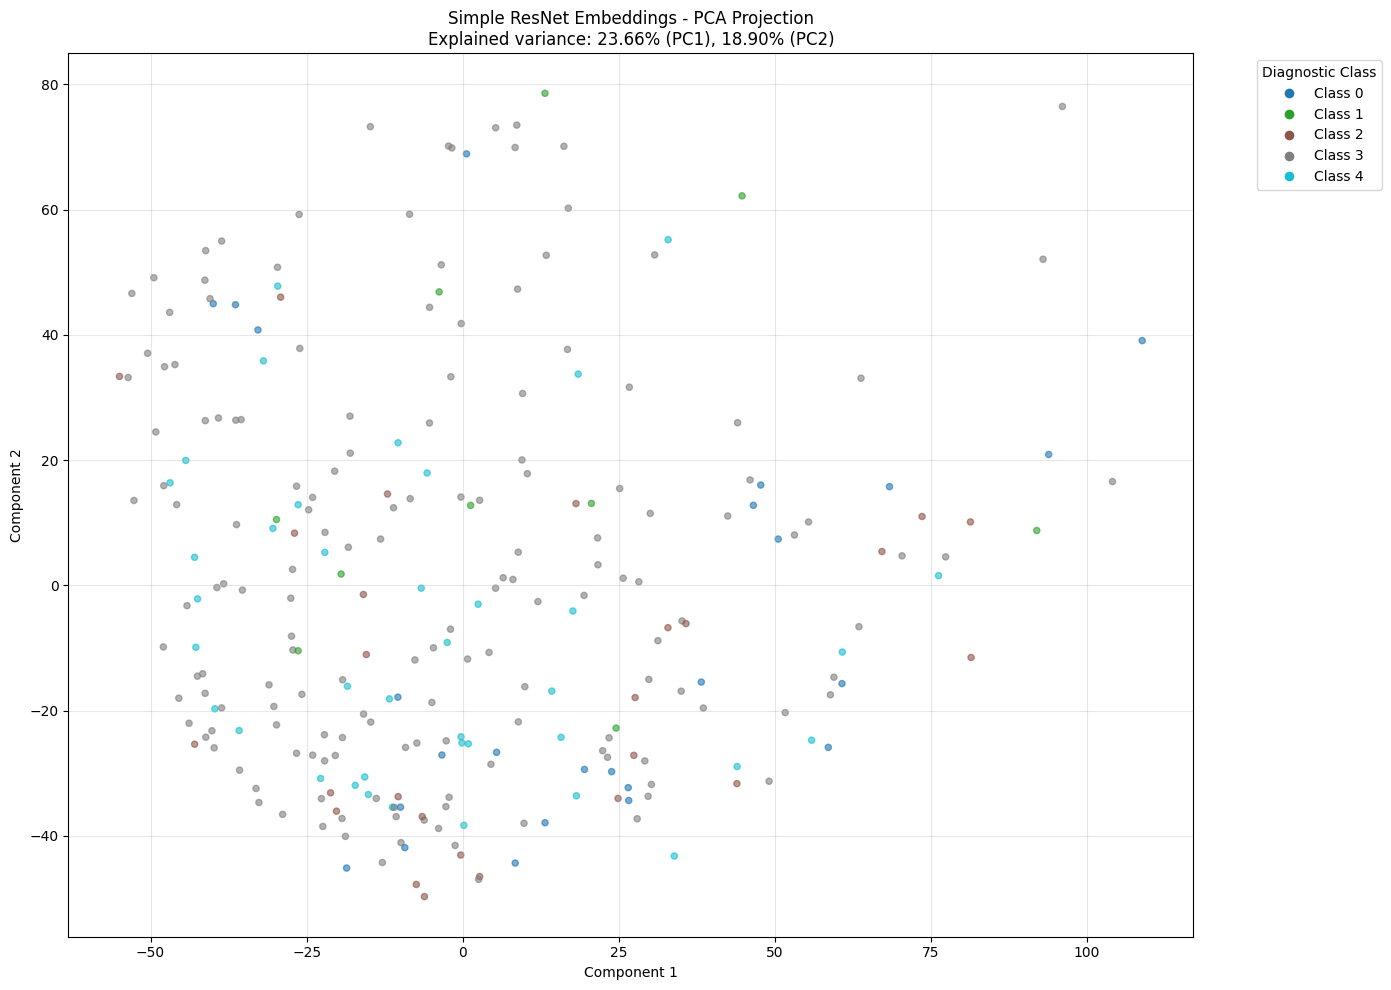

In [ ]:
# Visualize simple model embeddings with PCA
print("\nGenerating PCA visualization for simple model...")
simple_embeddings_2d_pca, _ = plot_embeddings_2d(
    simple_embeddings, 
    simple_labels, 
    method='pca', 
    title='Simple ResNet Embeddings - PCA Projection',
    figsize=(14, 10)
)


Generating t-SNE visualization for simple model...


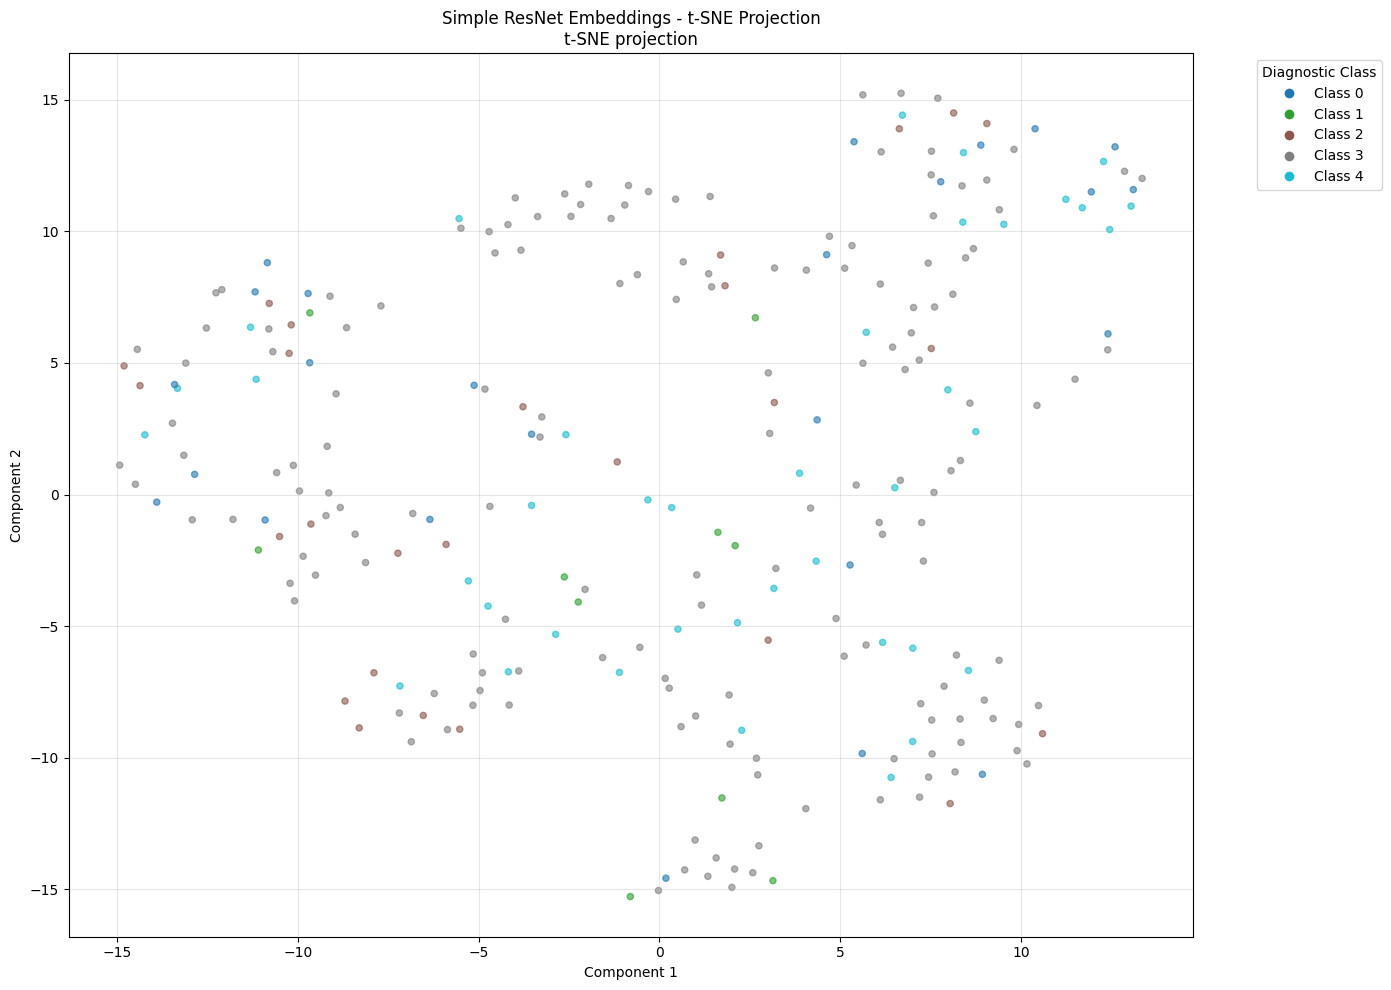

In [ ]:
# Visualize simple model embeddings with t-SNE
print("\nGenerating t-SNE visualization for simple model...")
simple_embeddings_2d_tsne, _ = plot_embeddings_2d(
    simple_embeddings, 
    simple_labels, 
    method='tsne', 
    title='Simple ResNet Embeddings - t-SNE Projection',
    figsize=(14, 10)
)

## Final Comparison & Analysis

Let's create a comprehensive comparison between the two models to identify what's working and what's not.

In [ ]:
# Comprehensive comparison table
import pandas as pd

comparison_data = {
    'Metric': [
        'Total Parameters',
        'Final Training Loss',
        'Final Validation Loss',
        'Best Validation Loss',
        'Silhouette Score',
        'Davies-Bouldin Score',
        'Calinski-Harabasz Score',
        'Embedding Dimension'
    ],
    'Complex Transformer': [
        f"{sum(p.numel() for p in model.parameters()):,}",
        f"{history['loss_history'][-1]:.4f}",
        f"{history.get('val_loss_history', [0])[-1]:.4f}" if 'val_loss_history' in history else "N/A",
        f"{min(history.get('val_loss_history', [0])):.4f}" if 'val_loss_history' in history else "N/A",
        f"{metrics['silhouette_score']:.4f}",
        f"{metrics['davies_bouldin_score']:.4f}",
        f"{metrics['calinski_harabasz_score']:.2f}",
        f"{embeddings.shape[1]}"
    ],
    'Simple ResNet': [
        f"{sum(p.numel() for p in simple_model.parameters()):,}",
        f"{simple_history['loss_history'][-1]:.4f}",
        f"{simple_history.get('val_loss_history', [0])[-1]:.4f}" if 'val_loss_history' in simple_history else "N/A",
        f"{min(simple_history.get('val_loss_history', [0])):.4f}" if 'val_loss_history' in simple_history else "N/A",
        f"{simple_metrics['silhouette_score']:.4f}",
        f"{simple_metrics['davies_bouldin_score']:.4f}",
        f"{simple_metrics['calinski_harabasz_score']:.2f}",
        f"{simple_embeddings.shape[1]}"
    ],
    'Better': [
        'Simple (fewer params)',
        'Lower is better',
        'Lower is better',
        'Lower is better',
        'Higher is better',
        'Lower is better',
        'Higher is better',
        'N/A'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "=" * 100)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 100)
print(comparison_df.to_string(index=False))
print("=" * 100)

# Determine winner for each metric
print("\n📊 METRIC-BY-METRIC ANALYSIS:\n")

def compare_metric(name, complex_val, simple_val, higher_better=False):
    try:
        c = float(complex_val)
        s = float(simple_val)
        if higher_better:
            winner = "Simple ResNet" if s > c else "Complex Transformer"
            diff = ((s - c) / abs(c)) * 100
        else:
            winner = "Simple ResNet" if s < c else "Complex Transformer"
            diff = ((c - s) / abs(c)) * 100
        print(f"  {name:30s}: {winner:20s} (difference: {abs(diff):+.1f}%)")
    except:
        print(f"  {name:30s}: Unable to compare")

compare_metric("Training Loss", history['loss_history'][-1], simple_history['loss_history'][-1], False)
if 'val_loss_history' in history and 'val_loss_history' in simple_history:
    compare_metric("Validation Loss", history['val_loss_history'][-1], simple_history['val_loss_history'][-1], False)
compare_metric("Silhouette Score", metrics['silhouette_score'], simple_metrics['silhouette_score'], True)
compare_metric("Davies-Bouldin Score", metrics['davies_bouldin_score'], simple_metrics['davies_bouldin_score'], False)
compare_metric("Calinski-Harabasz Score", metrics['calinski_harabasz_score'], simple_metrics['calinski_harabasz_score'], True)

print("\n" + "=" * 100)

NameError: name 'model' is not defined

# Downstream classification

## Simple Classifier with Frozen Encoder

We'll use the pre-trained encoder as a frozen feature extractor and add a simple classification head on top. This allows us to evaluate the quality of the learned representations on downstream classification tasks.

In [33]:
import torch

import torch.nn as nn

from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

from tqdm import tqdm





class SimpleClassifier(nn.Module):

    """

    Simple classifier that uses an encoder as backbone.

    

    Args:

        encoder: Pre-trained encoder model

        num_classes: Number of output classes

        hidden_dim: Hidden dimension for classification head (optional)

        encoder_dim: Output dimension of the encoder

        freeze_encoder: If True, freeze encoder weights; if False, allow joint training

    """

    

    def __init__(self, encoder, num_classes, hidden_dim=None, encoder_dim=1024, freeze_encoder=False):

        super().__init__()

        self.encoder = encoder

        self._apply_freeze_state(freeze_encoder)

        

        # Classification head

        if hidden_dim is not None:

            self.classifier = nn.Sequential(

                nn.Linear(encoder_dim, hidden_dim),

                nn.ReLU(),

                nn.Dropout(0.3),

                nn.Linear(hidden_dim, num_classes)

            )

        else:

            self.classifier = nn.Linear(encoder_dim, num_classes)

    

    def _apply_freeze_state(self, freeze: bool) -> None:

        """Synchronize encoder grad state and mode with the requested freeze flag."""

        self.freeze_encoder = freeze

        for param in self.encoder.parameters():

            param.requires_grad = not freeze

        # train(mode=False) switches to eval; keeps BatchNorm/dropout consistent

        self.encoder.train(mode=not freeze)

    

    def forward(self, x):

        # Extract features (with or without gradients based on freeze_encoder)

        if self.freeze_encoder:

            with torch.no_grad():

                features, _ = self.encoder(x)

        else:

            features, _ = self.encoder(x)

        

        # Classify

        logits = self.classifier(features.to(x.dtype))

        return logits





def train_classifier(

    encoder,

    train_loader,

    val_loader,

    num_classes,

    hidden_dim=256,

    num_epochs=20,

    learning_rate=1e-3,

    device=None,

    patience=5,
    encoder_dim=1024,

    freeze_encoder=True,

    encoder_lr=1e-4

):

    """

    Train a classifier on top of an encoder.

    

    Args:

        encoder: Pre-trained encoder model

        train_loader: DataLoader for training data (with numerical labels)

        val_loader: DataLoader for validation data (with numerical labels)

        num_classes: Number of classes

        hidden_dim: Hidden dimension for classification head

        num_epochs: Maximum number of training epochs

        learning_rate: Learning rate for classifier head

        device: Device to train on

        patience: Early stopping patience

        freeze_encoder: If True, freeze encoder; if False, train encoder jointly

        encoder_lr: Learning rate for encoder (only used if freeze_encoder=False)

    

    Returns:

        model: Trained classifier

        history: Dictionary containing training history

    """

    if device is None:

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    

    # Create model

    model = SimpleClassifier(encoder, num_classes, hidden_dim=hidden_dim, encoder_dim=encoder_dim, 

                            freeze_encoder=freeze_encoder)

    model = model.to(device)

    

    # Loss function

    criterion = nn.CrossEntropyLoss()

    

    # Optimizer setup based on freeze_encoder flag

    if freeze_encoder:

        # Only optimize classifier parameters

        optimizer = torch.optim.Adam(model.classifier.parameters(), lr=learning_rate)

    else:

        # Optimize both encoder and classifier with different learning rates

        optimizer = torch.optim.Adam([

            {'params': model.encoder.parameters(), 'lr': encoder_lr},

            {'params': model.classifier.parameters(), 'lr': learning_rate}

        ])

    

    # Training history

    history = {

        'train_loss': [],

        'train_acc': [],

        'val_loss': [],

        'val_acc': [],

        'val_f1': []

    }

    

    best_val_acc = 0.0

    patience_counter = 0

    best_model_state = None

    

    # Print training configuration

    print(f"Training classifier on {device}")

    print(f"Training mode: {'Frozen encoder' if freeze_encoder else 'Joint training (encoder + classifier)'}")

    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    print(f"Frozen parameters: {sum(p.numel() for p in model.parameters() if not p.requires_grad):,}")

    if not freeze_encoder:

        print(f"Encoder learning rate: {encoder_lr}")

        print(f"Classifier learning rate: {learning_rate}")

    else:

        print(f"Classifier learning rate: {learning_rate}")

    print()

    

    for epoch in range(num_epochs):

        # Training phase

        model.train()

        if freeze_encoder:

            model.encoder.eval()  # Keep encoder in eval mode when frozen

        

        train_loss = 0.0

        train_preds = []

        train_labels = []

        

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for signals, labels in pbar:

            signals, labels = signals.to(device), labels.to(device)
            

            # Forward pass

            optimizer.zero_grad()

            logits = model(signals)

            loss = criterion(logits, labels)
            

            # Backward pass

            loss.backward()

            optimizer.step()
            

            # Track metrics

            train_loss += loss.item() * signals.size(0)

            train_preds.extend(logits.argmax(dim=1).cpu().numpy())

            train_labels.extend(labels.cpu().numpy())
            

            pbar.set_postfix({'loss': loss.item()})

        # Calculate training metrics

        train_loss = train_loss / len(train_loader.dataset)

        train_acc = accuracy_score(train_labels, train_preds)

        

        # Validation phase

        model.eval()

        val_loss = 0.0

        val_preds = []

        val_labels = []

        

        with torch.no_grad():

            for signals, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]  ', leave=False):

                signals, labels = signals.to(device), labels.to(device)
                

                logits = model(signals)

                loss = criterion(logits, labels)
                

                val_loss += loss.item() * signals.size(0)

                val_preds.extend(logits.argmax(dim=1).cpu().numpy())

                val_labels.extend(labels.cpu().numpy())

        # Calculate validation metrics

        val_loss = val_loss / len(val_loader.dataset)

        val_acc = accuracy_score(val_labels, val_preds)

        val_f1 = f1_score(val_labels, val_preds, average='weighted')

        

        # Store history

        history['train_loss'].append(train_loss)

        history['train_acc'].append(train_acc)

        history['val_loss'].append(val_loss)

        history['val_acc'].append(val_acc)

        history['val_f1'].append(val_f1)

        

        # Print epoch summary

        print(f'Epoch {epoch+1}/{num_epochs}:')

        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

        print(f'  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}, Val F1: {val_f1:.4f}')

        

        # Early stopping

        if val_acc > best_val_acc:

            best_val_acc = val_acc

            patience_counter = 0

            best_model_state = model.state_dict().copy()

            print(f'  ✓ New best validation accuracy!')

        else:

            patience_counter += 1

            if patience_counter >= patience:

                print(f'\nEarly stopping triggered after {epoch+1} epochs')

                break

        print()

    

    # Load best model

    if best_model_state is not None:

        model.load_state_dict(best_model_state)

    

    return model, history





def evaluate_classifier(model, test_loader, idx_to_label=None, device=None):

    """

    Evaluate classifier on test set.

    

    Args:

        model: Trained classifier

        test_loader: DataLoader for test data

        idx_to_label: Optional mapping from indices to label names

        device: Device to run evaluation on

    

    Returns:

        metrics: Dictionary with evaluation metrics

    """

    if device is None:

        device = next(model.parameters()).device

    

    model.eval()

    all_preds = []

    all_labels = []

    

    with torch.no_grad():

        for signals, labels in tqdm(test_loader, desc='Evaluating'):

            signals, labels = signals.to(device), labels.to(device)
            

            logits = model(signals)

            preds = logits.argmax(dim=1)
            

            all_preds.extend(preds.cpu().numpy())

            all_labels.extend(labels.cpu().numpy())

    

    # Calculate metrics

    accuracy = accuracy_score(all_labels, all_preds)

    f1_weighted = f1_score(all_labels, all_preds, average='weighted')

    f1_macro = f1_score(all_labels, all_preds, average='macro')

    precision = precision_score(all_labels, all_preds, average='weighted')

    recall = recall_score(all_labels, all_preds, average='weighted')

    

    metrics = {

        'accuracy': accuracy,

        'f1_weighted': f1_weighted,

        'f1_macro': f1_macro,

        'precision': precision,

        'recall': recall,

        'predictions': all_preds,

        'labels': all_labels

    }

    

    # Print results

    print("=" * 60)

    print("TEST SET EVALUATION")

    print("=" * 60)

    print(f"Accuracy:          {accuracy:.4f}")

    print(f"F1 Score (weighted): {f1_weighted:.4f}")

    print(f"F1 Score (macro):    {f1_macro:.4f}")

    print(f"Precision:         {precision:.4f}")

    print(f"Recall:            {recall:.4f}")

    print("=" * 60)

    print()

    

    # Classification report

    if idx_to_label is not None:

        target_names = [idx_to_label[i] for i in sorted(idx_to_label.keys())]

    else:

        target_names = None

    

    print("CLASSIFICATION REPORT:")

    print(classification_report(all_labels, all_preds, target_names=target_names))

    

    return metrics


In [34]:
# Train the classifier using the pre-trained encoder
train_loader_classification=DataLoader(train_dataset_classification, batch_size=128, shuffle=True)
val_loader_classification=DataLoader(val_dataset_classification, batch_size=128, shuffle=False)

classifier, training_history = train_classifier(
    encoder=model,  # Your pre-trained encoder
    train_loader=train_loader_classification,
    val_loader=val_loader_classification,
    num_classes=test_dataset_classification.num_classes,
    hidden_dim=512,
    num_epochs=10,
    encoder_dim=512,
    learning_rate=1e-3,
    patience=3000,
    freeze_encoder=True,  # Fine-tune the encoder as well
)

Training classifier on cuda
Training mode: Frozen encoder
Total parameters: 35,596,213
Trainable parameters: 265,221
Frozen parameters: 35,330,992
Classifier learning rate: 0.001



Epoch 1/10 [Train]: 100%|██████████| 7/7 [00:01<00:00,  5.83it/s, loss=1.04]


Epoch 1/10:
  Train Loss: 1.2395, Train Acc: 0.5813
  Val Loss:   1.0141, Val Acc:   0.6165, Val F1: 0.5309
  ✓ New best validation accuracy!



Epoch 2/10 [Train]: 100%|██████████| 7/7 [00:01<00:00,  5.91it/s, loss=1.11] 


Epoch 2/10:
  Train Loss: 0.9960, Train Acc: 0.6496
  Val Loss:   1.0163, Val Acc:   0.6391, Val F1: 0.5478
  ✓ New best validation accuracy!



Epoch 3/10 [Train]: 100%|██████████| 7/7 [00:01<00:00,  5.84it/s, loss=0.872]


Epoch 3/10:
  Train Loss: 0.9649, Train Acc: 0.6667
  Val Loss:   0.9987, Val Acc:   0.6466, Val F1: 0.5078
  ✓ New best validation accuracy!



Epoch 4/10 [Train]: 100%|██████████| 7/7 [00:01<00:00,  5.82it/s, loss=0.997]


Epoch 4/10:
  Train Loss: 0.9432, Train Acc: 0.6701
  Val Loss:   0.9796, Val Acc:   0.6466, Val F1: 0.5078



Epoch 5/10 [Train]: 100%|██████████| 7/7 [00:01<00:00,  5.83it/s, loss=0.912]


Epoch 5/10:
  Train Loss: 0.9337, Train Acc: 0.6712
  Val Loss:   0.9819, Val Acc:   0.6466, Val F1: 0.5102



Epoch 6/10 [Train]: 100%|██████████| 7/7 [00:01<00:00,  5.82it/s, loss=1]    


Epoch 6/10:
  Train Loss: 0.9222, Train Acc: 0.6678
  Val Loss:   0.9818, Val Acc:   0.6541, Val F1: 0.5410
  ✓ New best validation accuracy!



Epoch 7/10 [Train]: 100%|██████████| 7/7 [00:01<00:00,  5.82it/s, loss=0.881]


Epoch 7/10:
  Train Loss: 0.9101, Train Acc: 0.6746
  Val Loss:   0.9744, Val Acc:   0.6617, Val F1: 0.5461
  ✓ New best validation accuracy!



Epoch 8/10 [Train]: 100%|██████████| 7/7 [00:01<00:00,  5.83it/s, loss=0.876]


Epoch 8/10:
  Train Loss: 0.9091, Train Acc: 0.6780
  Val Loss:   0.9744, Val Acc:   0.6617, Val F1: 0.5461



Epoch 9/10 [Train]: 100%|██████████| 7/7 [00:01<00:00,  5.80it/s, loss=0.939]


Epoch 9/10:
  Train Loss: 0.9072, Train Acc: 0.6758
  Val Loss:   0.9827, Val Acc:   0.6617, Val F1: 0.5393



Epoch 10/10 [Train]: 100%|██████████| 7/7 [00:01<00:00,  5.78it/s, loss=0.854]


Epoch 10/10:
  Train Loss: 0.9027, Train Acc: 0.6849
  Val Loss:   0.9669, Val Acc:   0.6617, Val F1: 0.5461



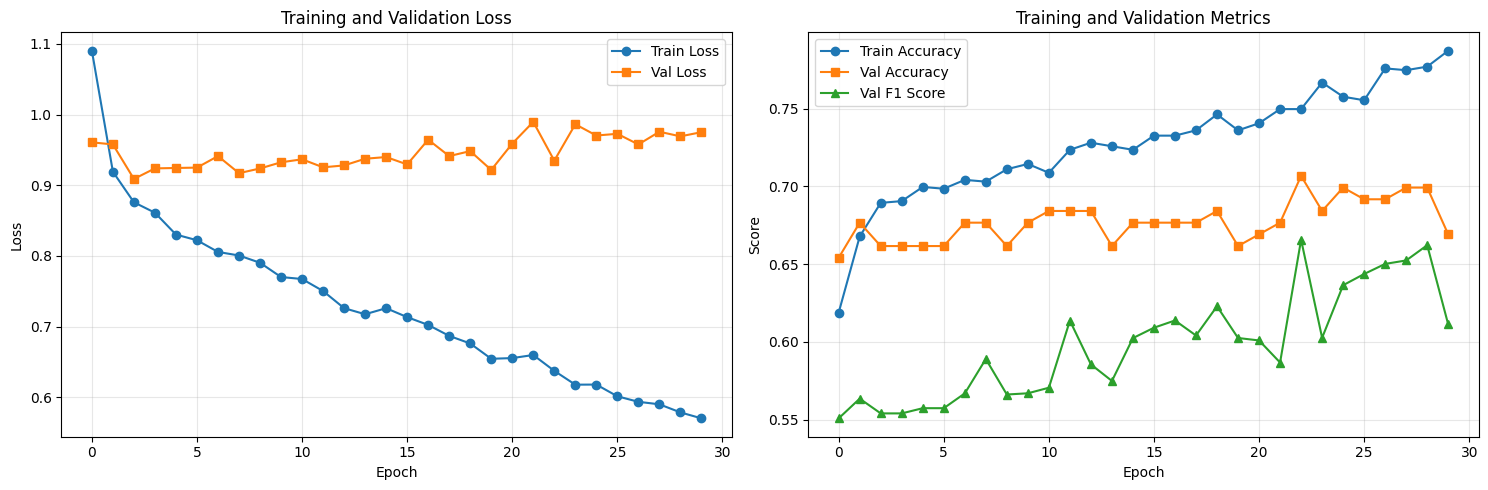


Best Training Accuracy: 0.7873
Best Validation Accuracy: 0.7068
Best Validation F1: 0.6657


In [27]:
# Plot training history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(training_history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(training_history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(training_history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(training_history['val_acc'], label='Val Accuracy', marker='s')
axes[1].plot(training_history['val_f1'], label='Val F1 Score', marker='^')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Training and Validation Metrics')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best results
print(f"\nBest Training Accuracy: {max(training_history['train_acc']):.4f}")
print(f"Best Validation Accuracy: {max(training_history['val_acc']):.4f}")
print(f"Best Validation F1: {max(training_history['val_f1']):.4f}")

In [28]:
# Evaluate on test set
test_metrics = evaluate_classifier(
    model=classifier,
    test_loader=test_loader_classification,
    idx_to_label=idx_to_label
)

Evaluating: 100%|██████████| 3/3 [00:00<00:00,  9.47it/s]

TEST SET EVALUATION
Accuracy:          0.6471
F1 Score (weighted): 0.5792
F1 Score (macro):    0.2935
Precision:         0.5337
Recall:            0.6471

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

          CD       0.43      0.40      0.41        15
         HYP       0.00      0.00      0.00         3
          MI       0.38      0.20      0.26        15
        NORM       0.70      0.91      0.79        99
        STTC       0.00      0.00      0.00        21

    accuracy                           0.65       153
   macro avg       0.30      0.30      0.29       153
weighted avg       0.53      0.65      0.58       153




/home/aimakeradmin/shady-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/aimakeradmin/shady-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/aimakeradmin/shady-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

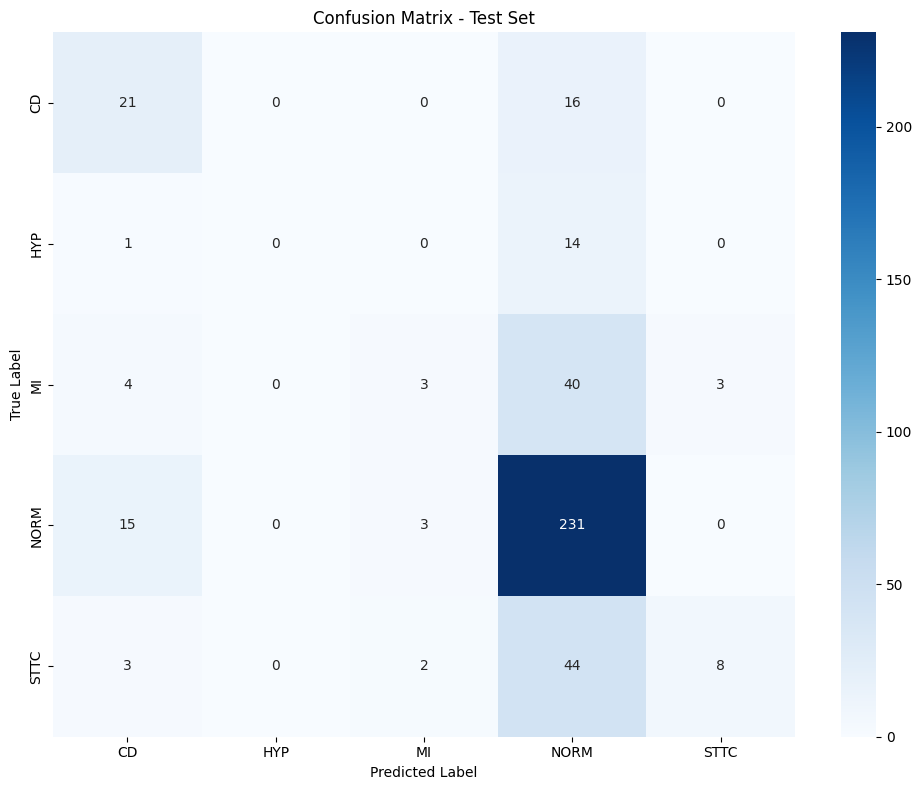


Per-Class Accuracy:
  CD                  : 0.5676 (21/37)
  HYP                 : 0.0000 (0/15)
  MI                  : 0.0600 (3/50)
  NORM                : 0.9277 (231/249)
  STTC                : 0.1404 (8/57)


In [62]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_metrics['labels'], test_metrics['predictions'])
class_names = [idx_to_label[i] for i in range(len(idx_to_label))]

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(class_names):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"  {class_name:20s}: {class_acc:.4f} ({cm[i, i]}/{cm[i].sum()})")

### Understanding the Results

The classifier evaluation provides insights into how well the pre-trained encoder's representations transfer to the downstream classification task:

**Key Metrics:**
- **Accuracy**: Overall percentage of correct predictions
- **F1 Score (Weighted)**: Harmonic mean of precision and recall, weighted by class support
- **F1 Score (Macro)**: Average F1 across all classes (treats all classes equally)
- **Precision**: Percentage of positive predictions that are correct
- **Recall**: Percentage of actual positives that are identified

**Interpreting Performance:**
- High test accuracy indicates good representation learning
- Compare with training from scratch to quantify the benefit of pre-training
- Per-class metrics reveal which diagnostic classes are easier/harder to classify
- Confusion matrix shows common misclassification patterns

**Architecture Notes:**
- The encoder is **frozen** (not updated during training)
- Only the classification head learns during training
- This tests the quality of the learned representations for downstream tasks

### Optional: Baseline Comparison

To validate that the pre-trained encoder learned useful representations, you can compare against a randomly initialized encoder:

In [ ]:
# Optional: Train classifier with random encoder (baseline)
# This helps quantify the benefit of pre-training

# Create a new random encoder with the same architecture
random_encoder = ECGEncoder(
    input_channels=12,
    d_model=512,
    nhead=8,
    num_layers=6,
    dim_feedforward=2048,
    dropout=0.1
).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Train classifier on random features
print("Training classifier with RANDOM encoder (baseline)...")
baseline_classifier, baseline_history = train_classifier(
    encoder=random_encoder,
    train_loader=train_loader_classification,
    val_loader=val_loader_classification,
    num_classes=test_dataset_classification.num_classes,
    hidden_dim=256,
    num_epochs=30,
    learning_rate=1e-3,
    patience=5
)

# Evaluate baseline
print("\n" + "="*60)
print("BASELINE EVALUATION (Random Encoder)")
print("="*60)
baseline_metrics = evaluate_classifier(
    model=baseline_classifier,
    test_loader=test_loader_classification,
    idx_to_label=idx_to_label
)

# Compare results
print("\n" + "="*60)
print("COMPARISON: Pre-trained vs Random Encoder")
print("="*60)
print(f"Pre-trained Encoder Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Random Encoder Test Accuracy:      {baseline_metrics['accuracy']:.4f}")
print(f"Improvement:                        {(test_metrics['accuracy'] - baseline_metrics['accuracy']):.4f}")
print(f"Relative Improvement:               {((test_metrics['accuracy'] - baseline_metrics['accuracy']) / baseline_metrics['accuracy'] * 100):.2f}%")
print("="*60)

---

## Summary: Downstream Classification Workflow

This section evaluates the quality of the learned encoder representations using a simple downstream classification task. Here's the complete workflow:

### 1. **Data Preparation**
   - Created datasets with numerical labels using `ECGDataset(map_labels_to_int=True)`
   - Split into train/val/test sets with proper DataLoaders

### 2. **Model Architecture**
   - `SimpleClassifier`: Frozen encoder + trainable classification head
   - Only the classification head parameters are updated during training
   - This isolates the evaluation to the encoder's representation quality

### 3. **Training**
   - Uses `train_classifier()` function that accepts any encoder
   - Early stopping based on validation accuracy
   - Tracks loss, accuracy, and F1 score
   - Returns trained model and training history

### 4. **Evaluation**
   - Comprehensive metrics: accuracy, F1 (weighted & macro), precision, recall
   - Classification report per class
   - Confusion matrix visualization
   - Per-class accuracy breakdown

### 5. **Baseline Comparison (Optional)**
   - Compare against randomly initialized encoder
   - Quantifies the benefit of contrastive pre-training
   - Shows relative improvement from learned representations

### Usage Example:
```python
# Train classifier
classifier, history = train_classifier(
    encoder=your_pretrained_encoder,
    train_loader=train_loader_classification,
    val_loader=val_loader_classification,
    num_classes=num_classes
)

# Evaluate
metrics = evaluate_classifier(
    model=classifier,
    test_loader=test_loader_classification
)
```

This approach is a standard method for evaluating self-supervised learning models on downstream tasks.